In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from nilearn import image as nimg
from nilearn import plotting as nplot
import bids
from nltools.file_reader import onsets_to_dm
from nltools.stats import regress, zscore
from nltools.data import Brain_Data, Design_Matrix
from nltools.stats import find_spikes 
from nilearn.plotting import view_img, glass_brain, plot_stat_map
from bids import BIDSLayout, BIDSValidator
import os
from pathlib import Path
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
from nilearn.plotting import plot_contrast_matrix
from nilearn.glm.first_level import FirstLevelModel
from nilearn import plotting
# creating mean img for plotting purposes 
from nilearn.image import mean_img
from nilearn.image import load_img
from nibabel import load
from nibabel.gifti import GiftiDataArray, GiftiImage
from nilearn.glm.first_level import run_glm as run_glm
from nilearn.glm import compute_contrast
import nilearn
fsaverage = nilearn.datasets.fetch_surf_fsaverage(mesh='fsaverage')

[fetch_surf_fsaverage] Dataset found in /Users/xiaoqianxiao/nilearn_data/fsaverage

[fetch_surf_fsaverage] Downloading data from https://osf.io/svf8k/download ...

[fetch_surf_fsaverage] Downloaded 835584 of 34242788 bytes (2.4%%,   40.1s remaining)

[fetch_surf_fsaverage] Downloaded 20496384 of 34242788 bytes (59.9%%,    1.3s remaining)

[fetch_surf_fsaverage]  ...done. (7 seconds, 0 min)

[fetch_surf_fsaverage] Extracting data from 
/Users/xiaoqianxiao/nilearn_data/fsaverage/735bf0f211246c83396b5f21f706c224/download...

[fetch_surf_fsaverage] .. done.

In [ ]:
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
drug_order_df = pd.read_excel(drug_order_file)
first_level_dir = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/derivatives/fMRI_analysis/ROI/first_level'
first_level_data_file = os.path.join(first_level_dir, 'phase2_data-new.xlsx')
file_lists_phase2 = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]
df_fMRI = pd.read_excel(first_level_data_file)

Extinction

In [22]:
file_lists_phase2

['CSR-CSS', 'CSR-CS-', 'CSS-CS-', 'CSR-fix', 'CSS-fix', 'CSminus-fix']

In [21]:
file_lists_phase2 = [
        "CSR-CSS",   
        "CSR-CS-",
        "CSS-CS-",
        "CSR-fix", 
        "CSS-fix",   
        "CSminus-fix"
        ]

In [ ]:
drug_order_file = '/Users/xiaoqianxiao/Projects/NARSAD/MRI/source_data/behav/drug_order.xlsx'
drug_order_df = pd.read_excel()
file_lists_phase2 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

file_lists_phase3 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

sub_order_phase2 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

sub_order_phase3 = {
        "CSR-CSS": list(),   
        "CSR-CS-": list(),
        "CSS-CS-": list(),
        "CSR-fix": list(), 
        "CSS-fix": list(),   
        "CSminus-fix": list()
        }

tasks = ['phase2','phase3']

In [3]:
file_lists_phase2

{'CSR-CSS': [],
 'CSR-CS-': [],
 'CSS-CS-': [],
 'CSR-fix': [],
 'CSS-fix': [],
 'CSminus-fix': []}

#### placebo 

In [9]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase2, contrast, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase2, drug_order_df)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


KeyError: 'DrugOrder'

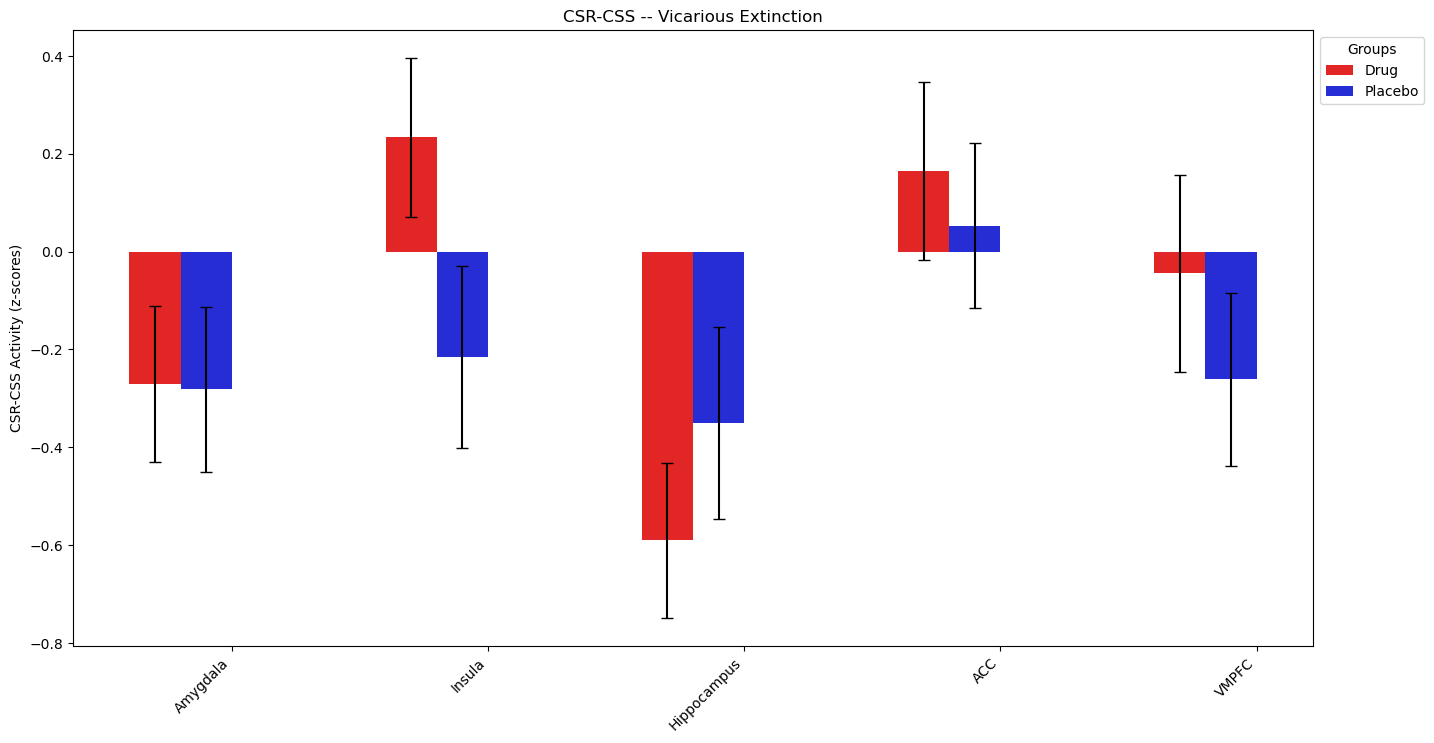

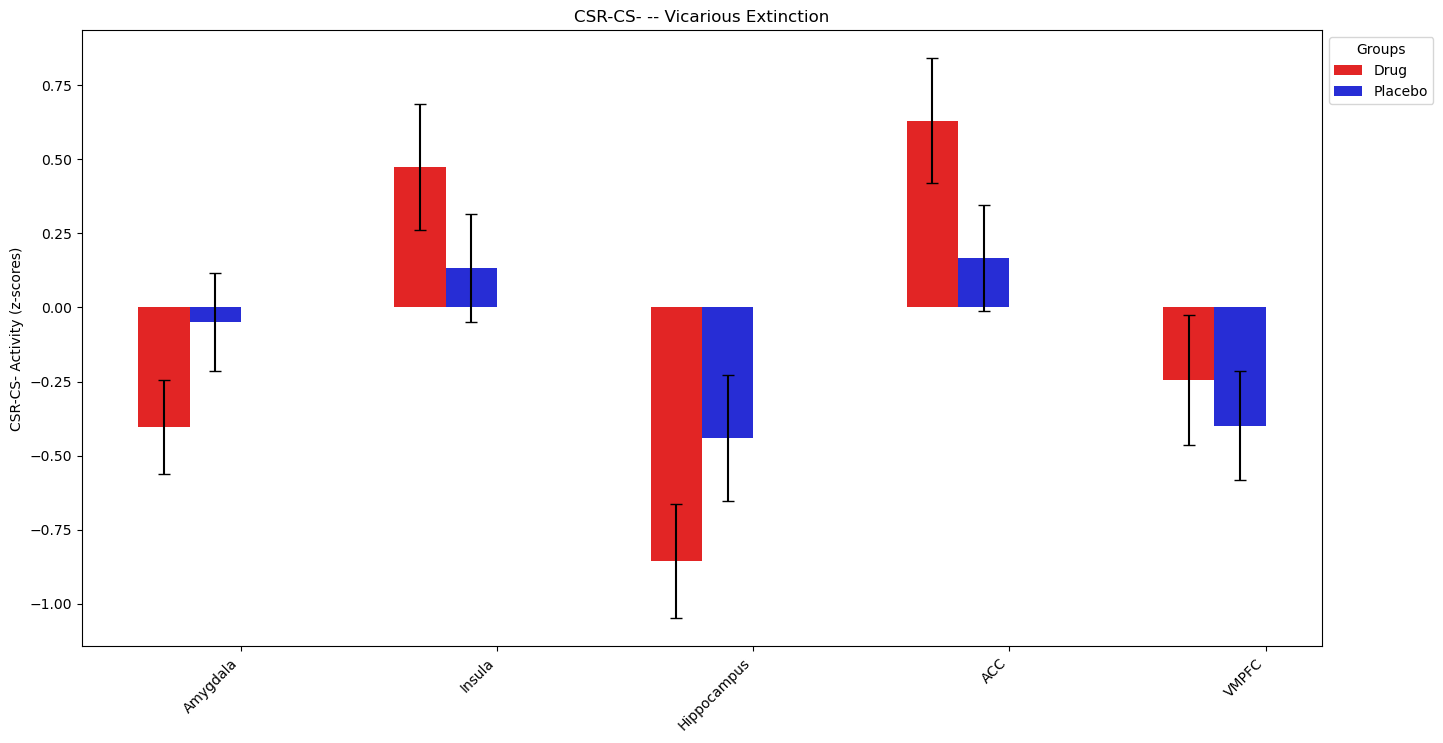

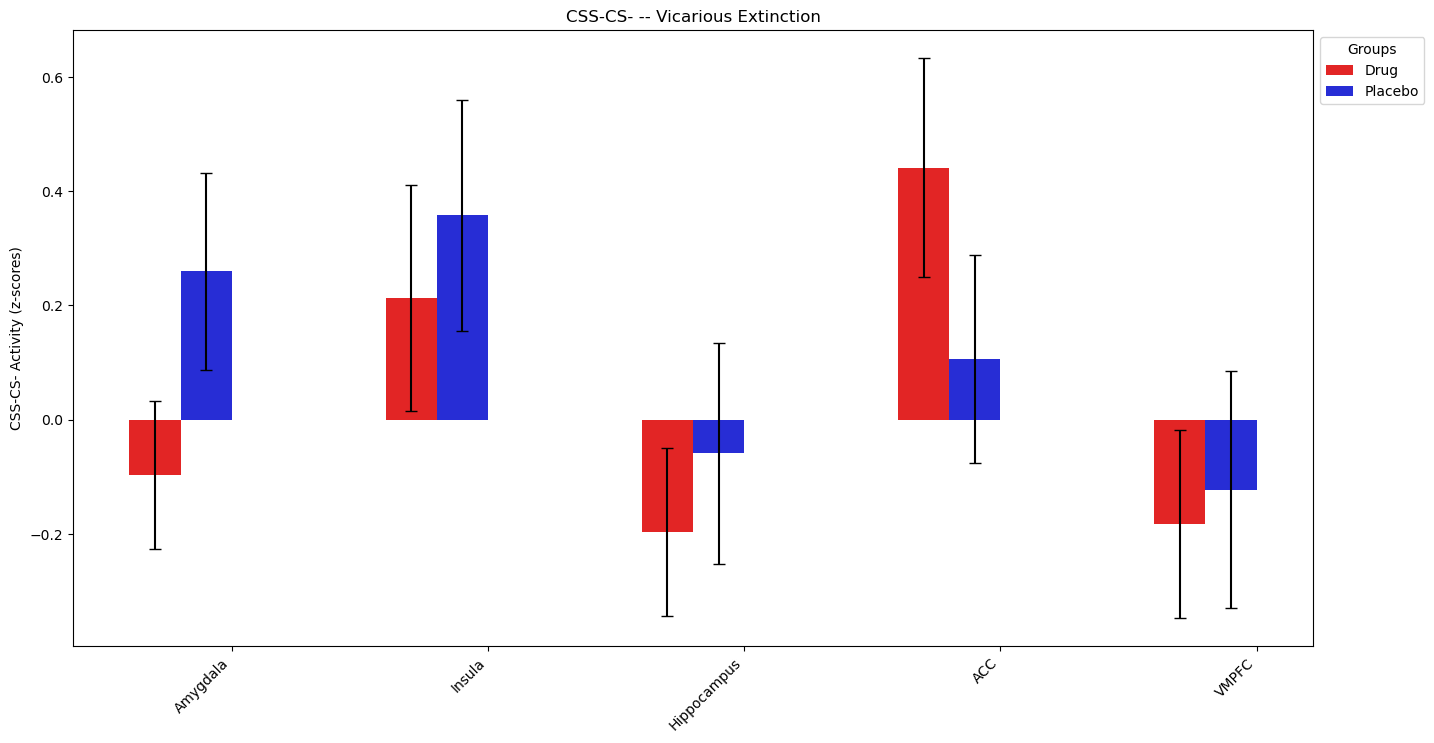

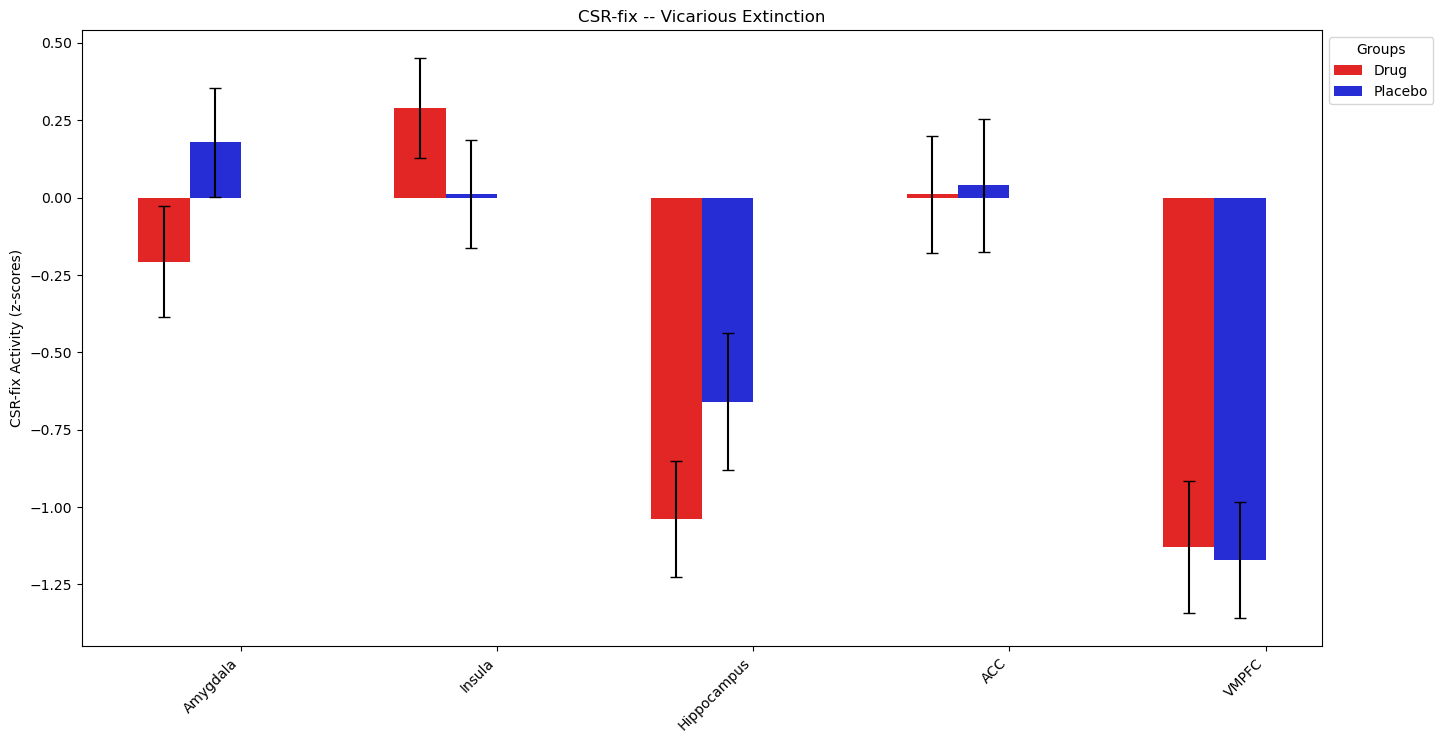

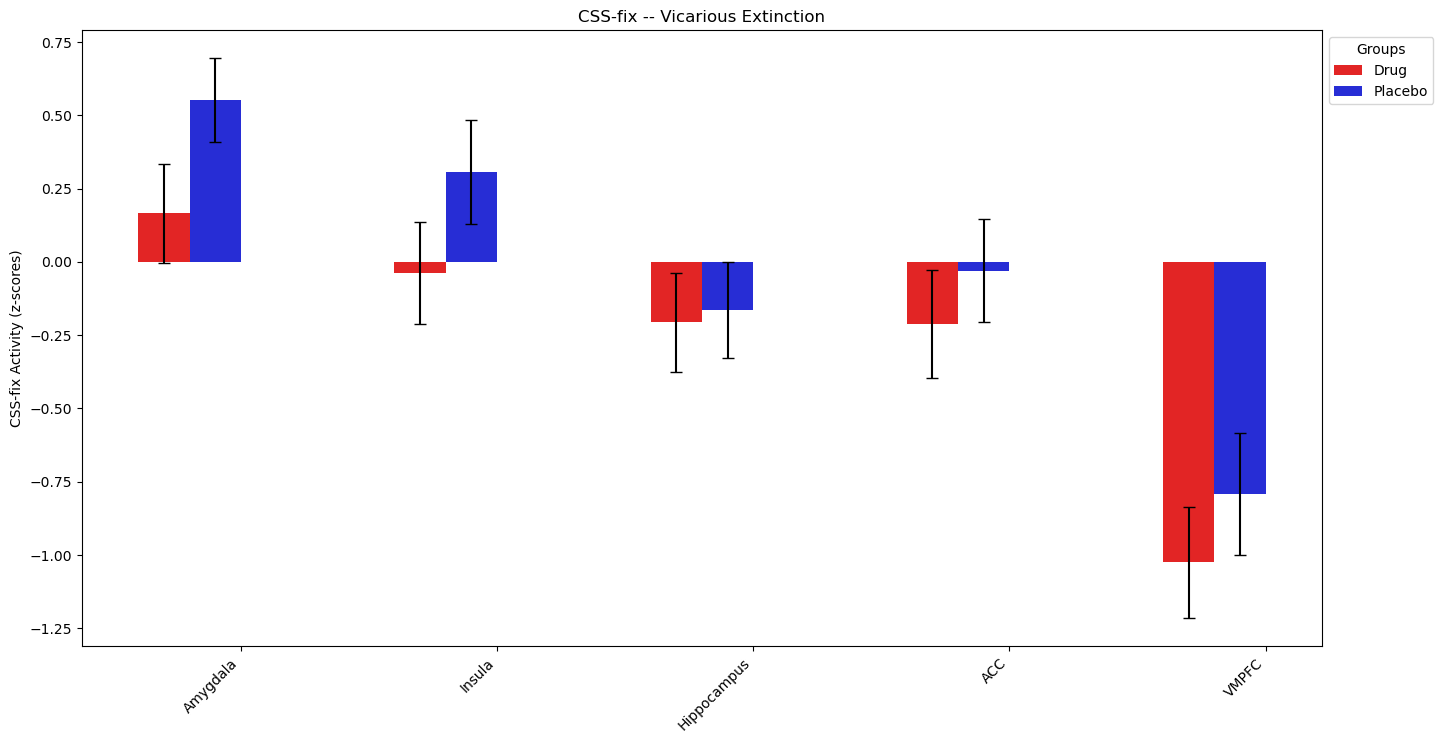

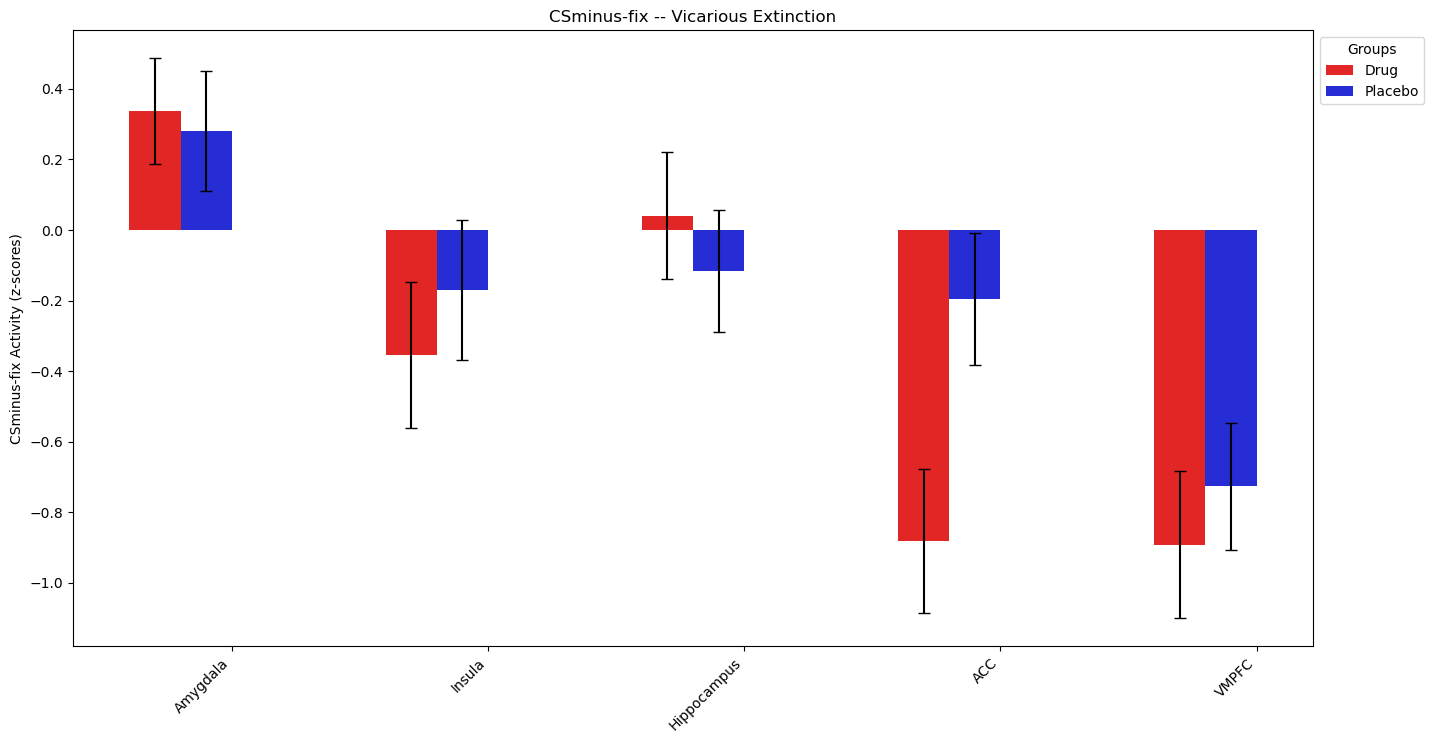

In [23]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1]    
    placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 0]
    return drug, placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['drug', 'placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    drug, placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'drug': group_stats(drug, data),
        'placebo': group_stats(placebo, data)
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#e22525", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')

#### wdrug 

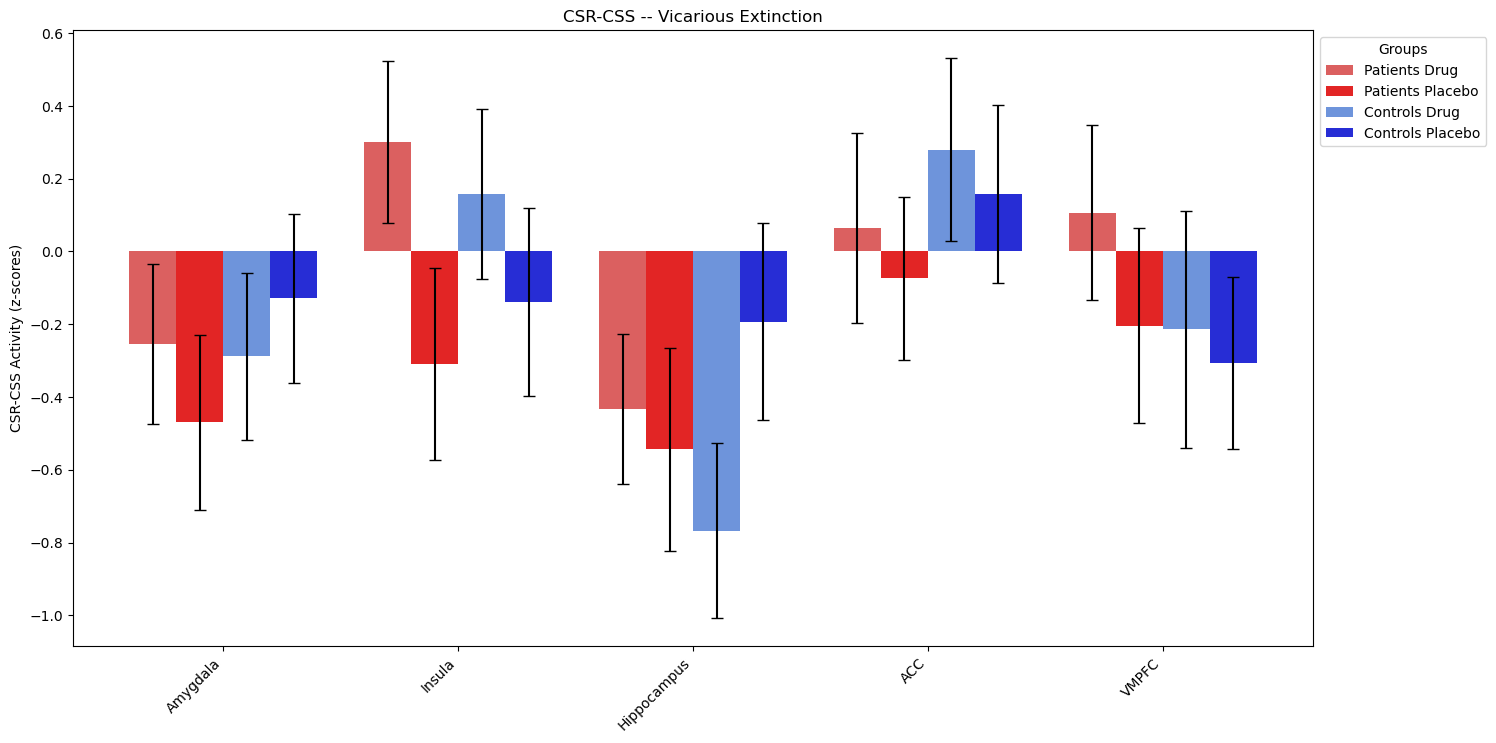

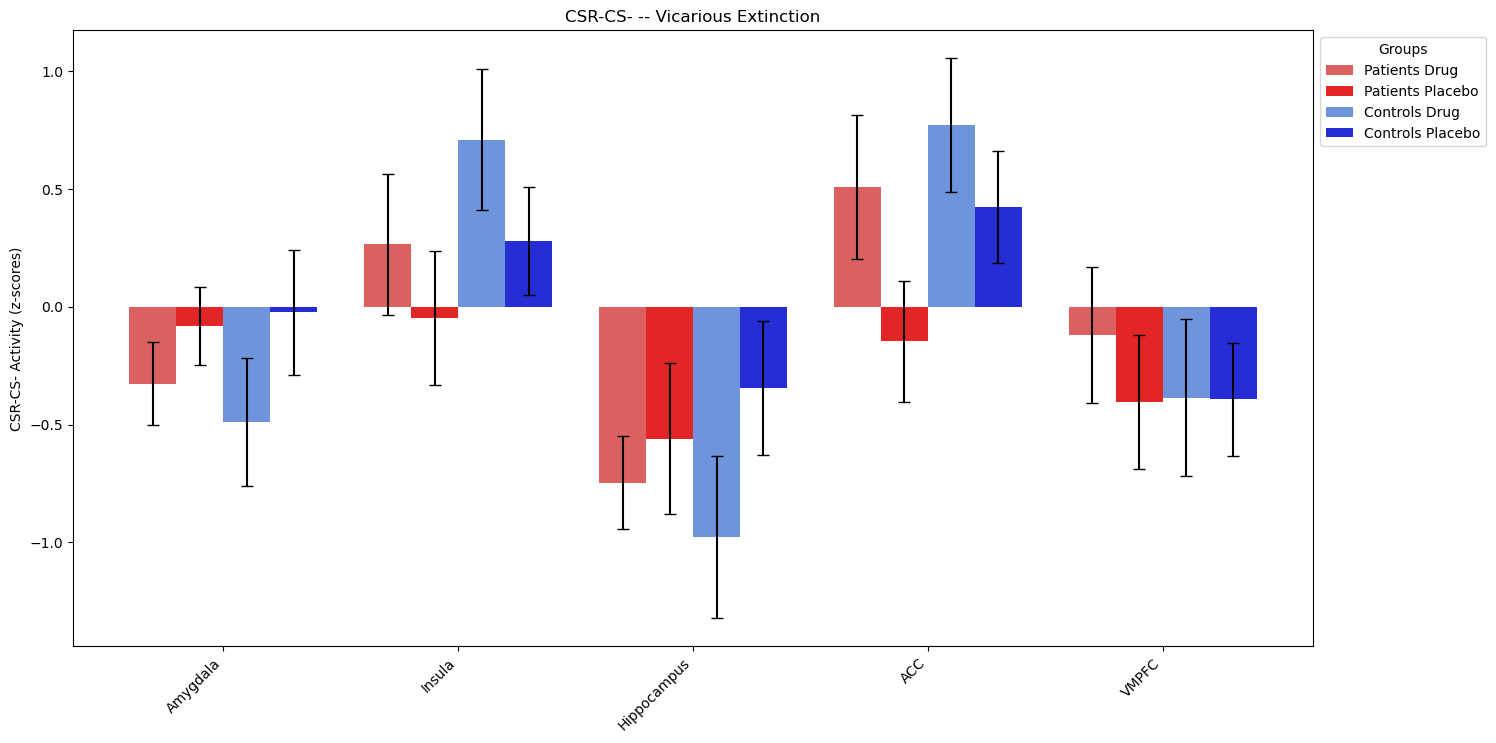

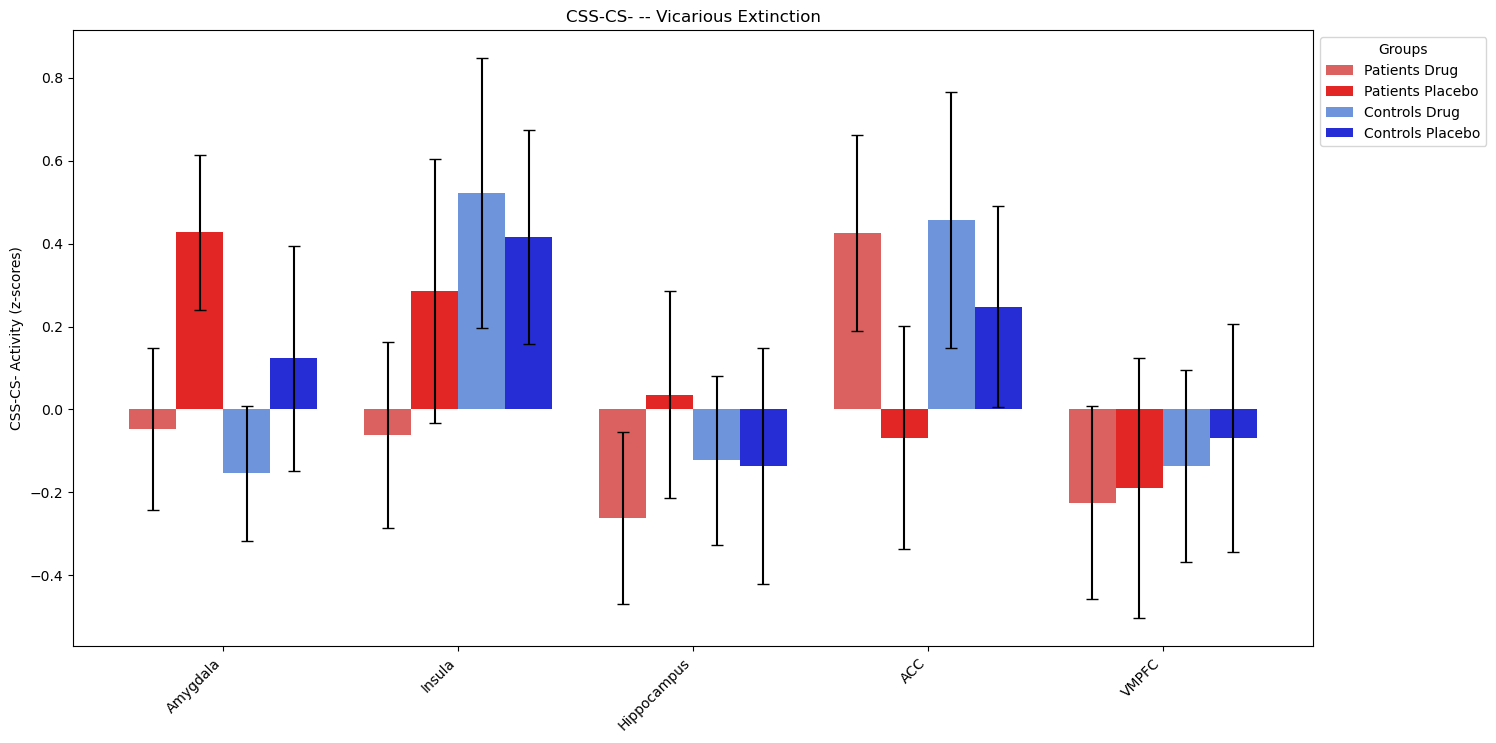

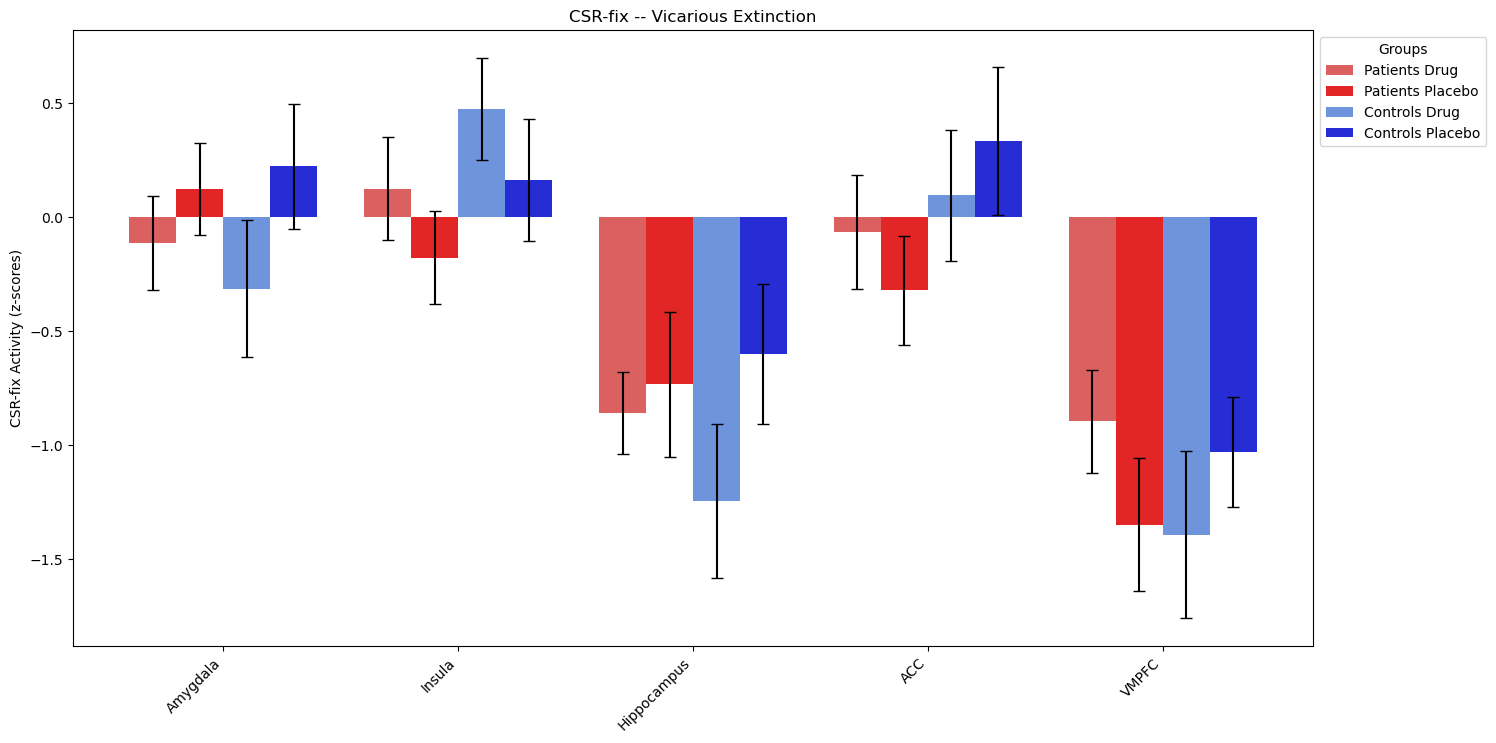

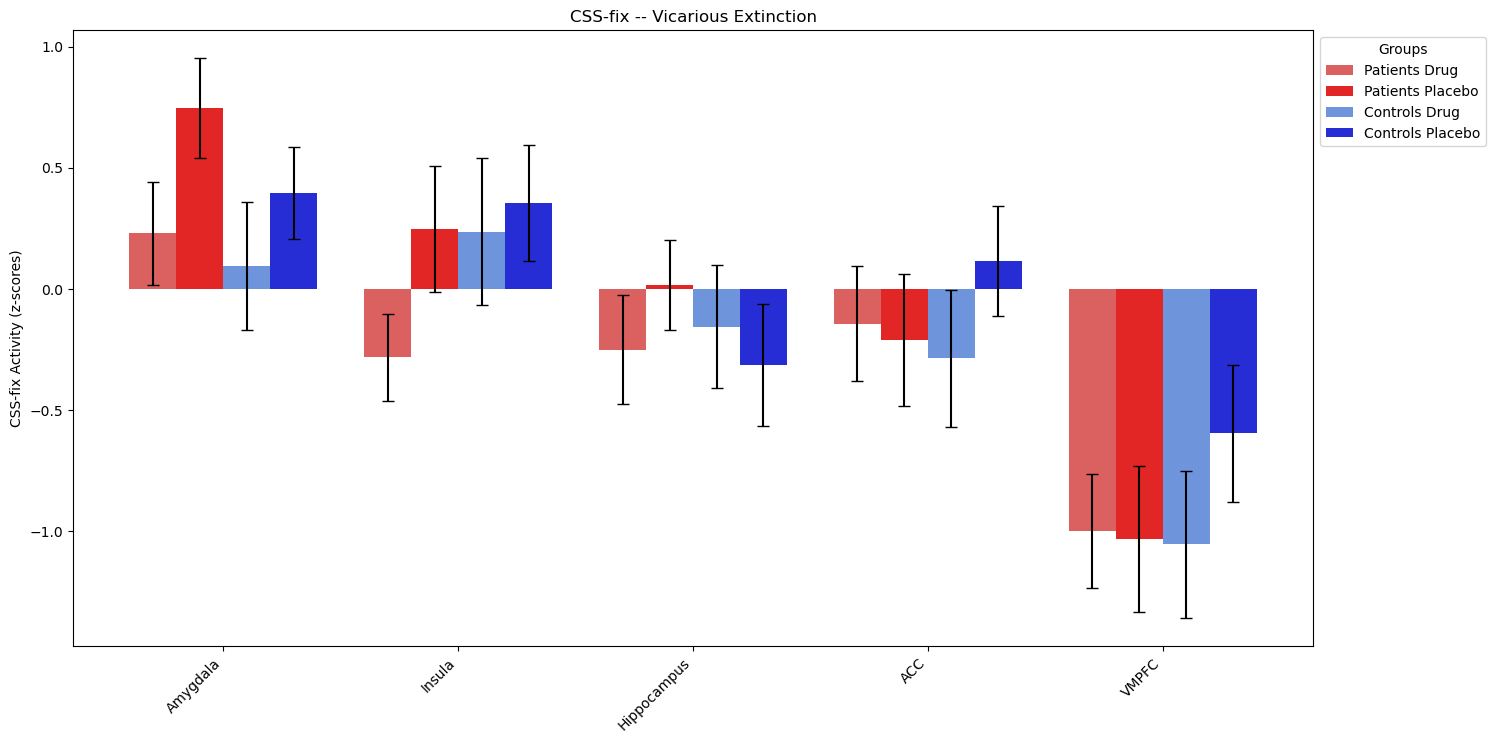

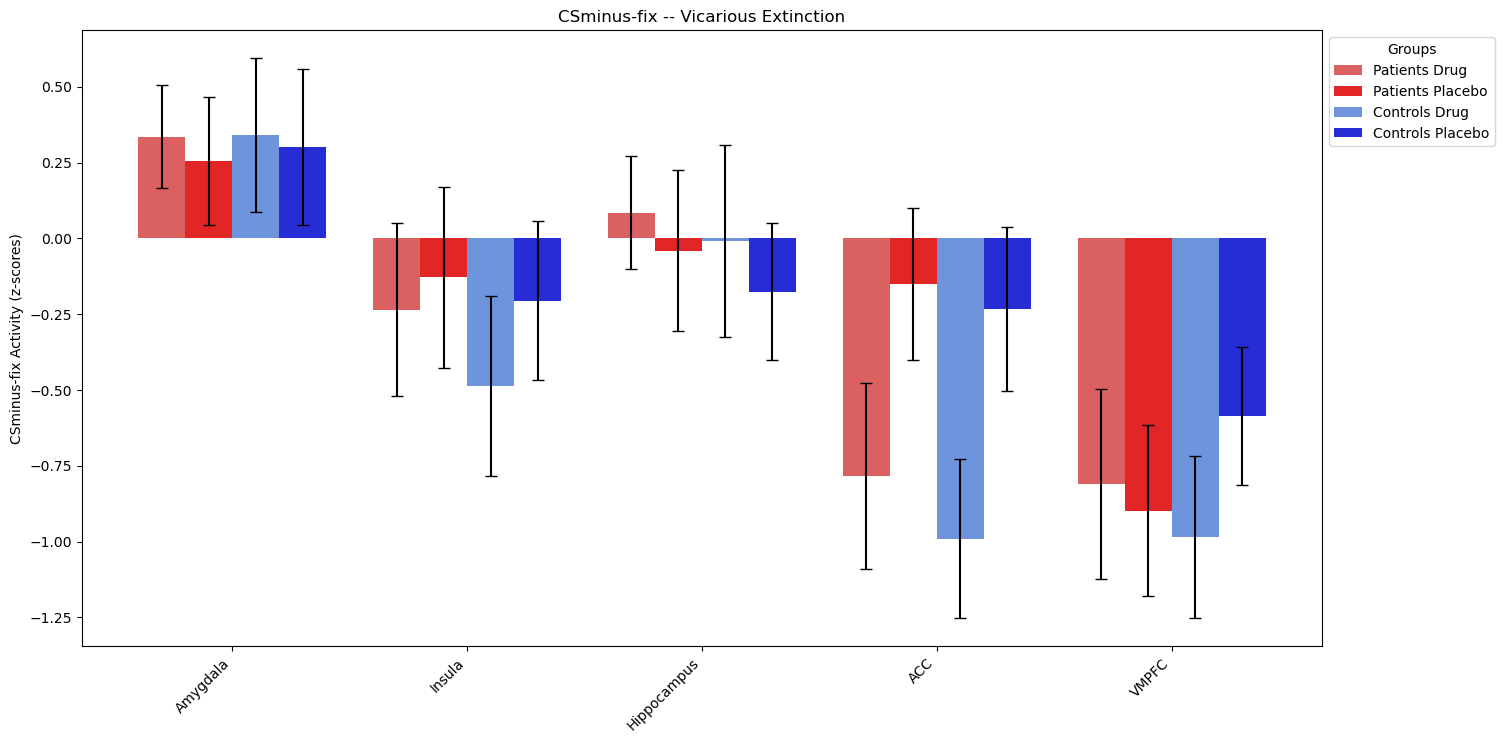

In [24]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug': group_stats(patients_drug, data),
        'patients_placebo': group_stats(patients_placebo, data),
        'controls_drug': group_stats(controls_drug, data),
        'controls_placebo': group_stats(controls_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase2[contrast]
    
    stats = extract_stats(region_data, sub_order_phase2[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')

In [27]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSminus-fix'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['drug','placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['drug'], stats['placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # # Controls Drug vs Placebo
        # t_stat, p_val = ttest_ind(stats['controls_drug'], stats['controls_placebo'])
        # comparisons.append({
        #     'Region': region,
        #     'Comparison': f'Controls Drug vs Placebo',
        #     't_stat': t_stat,
        #     'p_val': p_val
        # })
        
        # # Patients Drug vs Controls Drug
        # t_stat, p_val = ttest_ind(stats['patients_drug'], stats['controls_drug'])
        # comparisons.append({
        #     'Region': region,
        #     'Comparison': f'Patients Drug vs Controls Drug',
        #     't_stat': t_stat,
        #     'p_val': p_val
        # })
        
        # # Patients Placebo vs Controls Placebo
        # t_stat, p_val = ttest_ind(stats['patients_placebo'], stats['controls_placebo'])
        # comparisons.append({
        #     'Region': region,
        #     'Comparison': f'Patients Placebo vs Controls Placebo',
        #     't_stat': t_stat,
        #     'p_val': p_val
        # })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1]    
    placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 0]
    # controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    # controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return drug, placebo

# Retrieve groups by calling the function
drug, placebo = separate_groups_by_drug(sub_order_phase2[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase2[contrast]
    region_all_data = {
        'drug': extract_group_data(drug, region_data, region_no),
        'placebo': extract_group_data(placebo, region_data, region_no),
        # 'controls_drug': extract_group_data(controls_drug, region_data, region_no),
        # 'controls_placebo': extract_group_data(controls_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)

,Region,Comparison,t_stat,p_val
0,Amygdala,drug vs. 0,2.237798,0.029720
1,Amygdala,placebo vs. 0,1.627069,0.110270
2,Amygdala,Drug vs Placebo,0.248647,0.804154
3,Insula,drug vs. 0,-1.691698,0.096928
4,Insula,placebo vs. 0,-0.854887,0.396861
5,Insula,Drug vs Placebo,-0.630031,0.530141
6,Hippocampus,drug vs. 0,0.225257,0.822698
7,Hippocampus,placebo vs. 0,-0.661195,0.511649
8,Hippocampus,Drug vs Placebo,0.620117,0.536620
9,ACC,drug vs. 0,-4.275300,0.000086


In [79]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase2, contrast, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                 -0.012
Method:                 Least Squares   F-statistic:                    0.7644
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.578
Time:                        15:48:13   Log-Likelihood:                -148.24
No. Observations:                 100   AIC:                             308.5
Df Residuals:                      94   BIC:                             324.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I

### reinstatement - second-level

In [83]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df)

# ✅ Only keep placebo (DrugOrder == 0)
df = df[df['DrugOrder'] == 0]

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ PatientGroup + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.6653
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.519
Time:                        15:57:32   Log-Likelihood:                -81.463
No. Observations:                  50   AIC:                             168.9
Df Residuals:                      47   BIC:                             174.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.58

In [84]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast = 'CSS-CS-'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
data = extract_contrast_data(file_lists_phase3, contrast, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(dataex, sub_order, drug_order_df):
    data = []
    
    for region in dataex.keys():
        for idx, sub in enumerate(sub_order['CSR-CSS']):
            subID = sub[3:7]
            values = [dataex[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for y in values:
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup + DrugOrder * Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.3794
Date:                Fri, 19 Sep 2025   Prob (F-statistic):              0.862
Time:                        15:59:13   Log-Likelihood:                -165.67
No. Observations:                 101   AIC:                             343.3
Df Residuals:                      95   BIC:                             359.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
I

##### drug vs group post-hoc

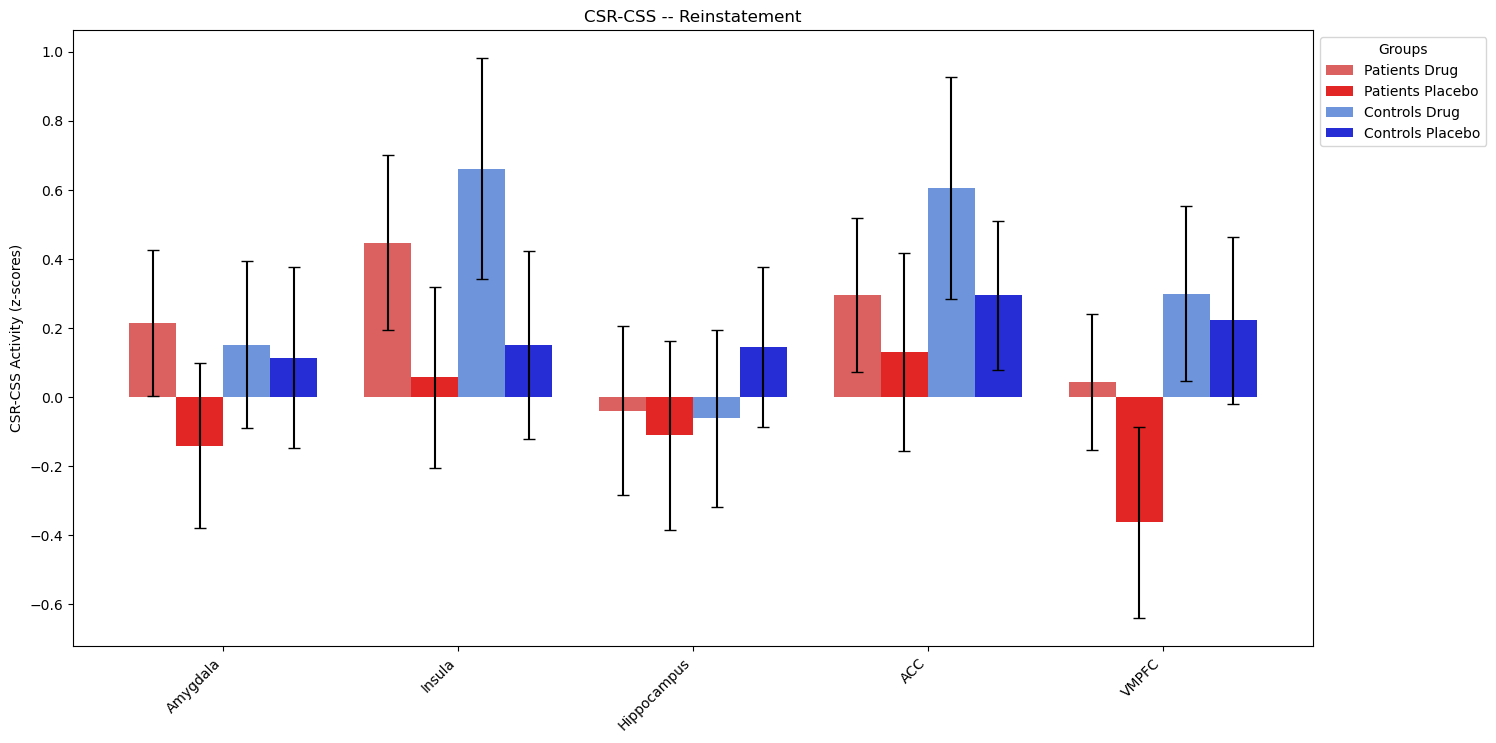

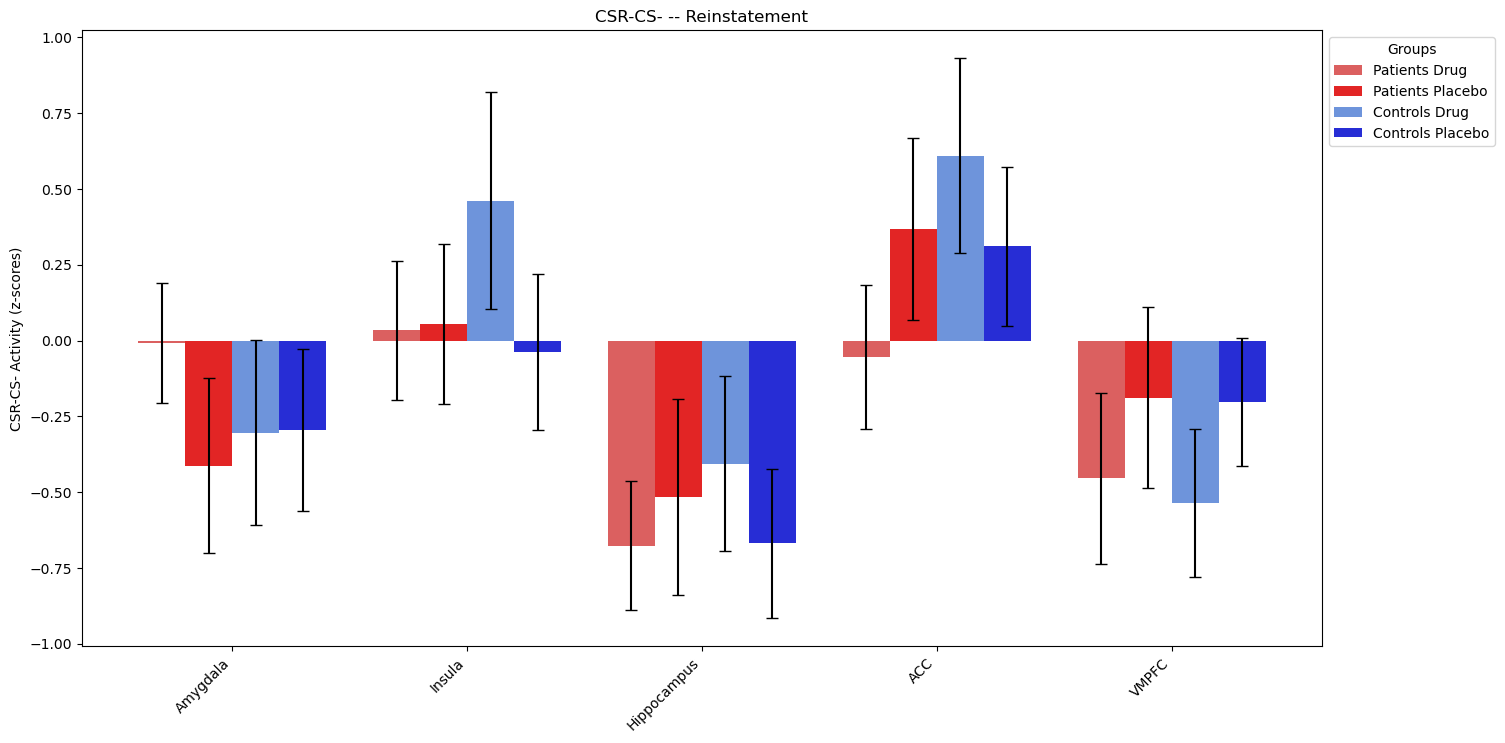

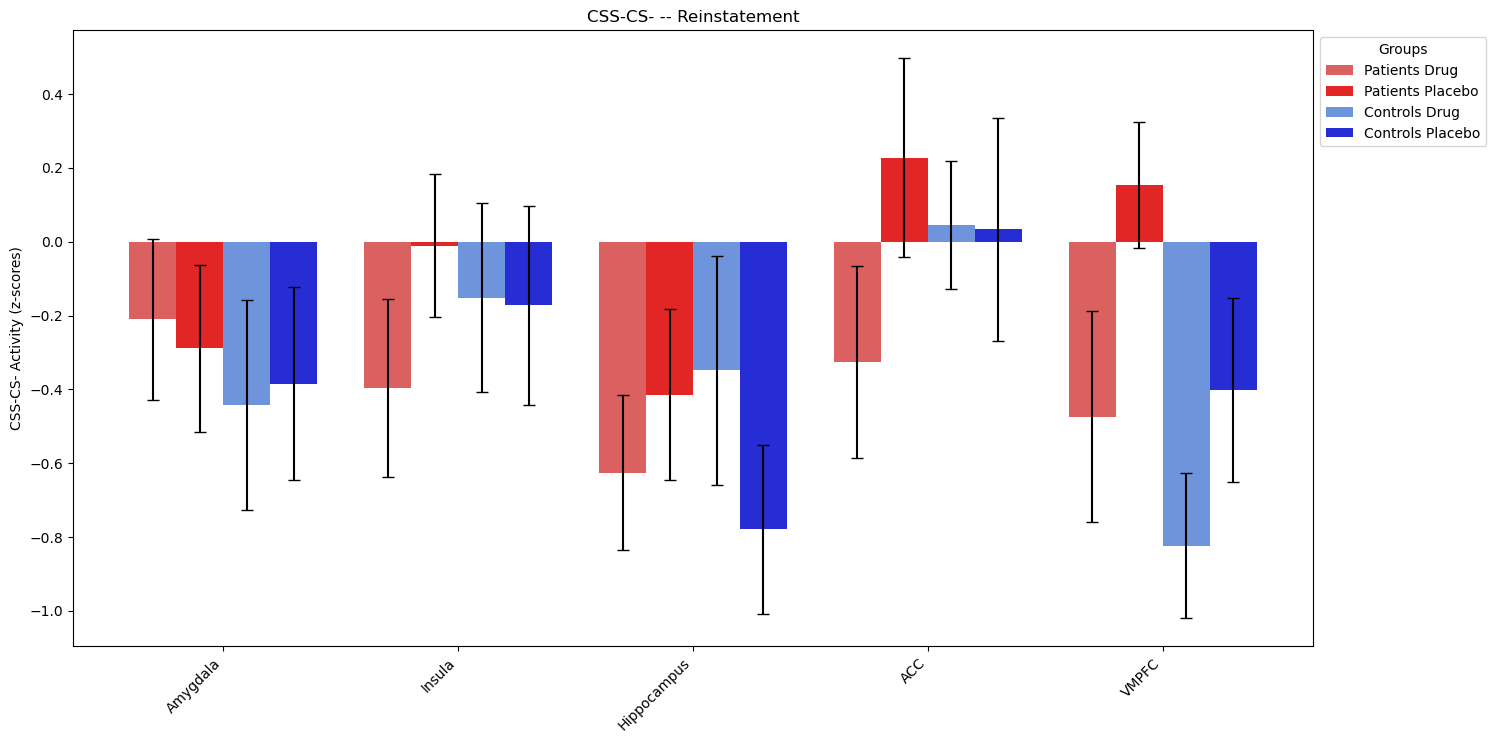

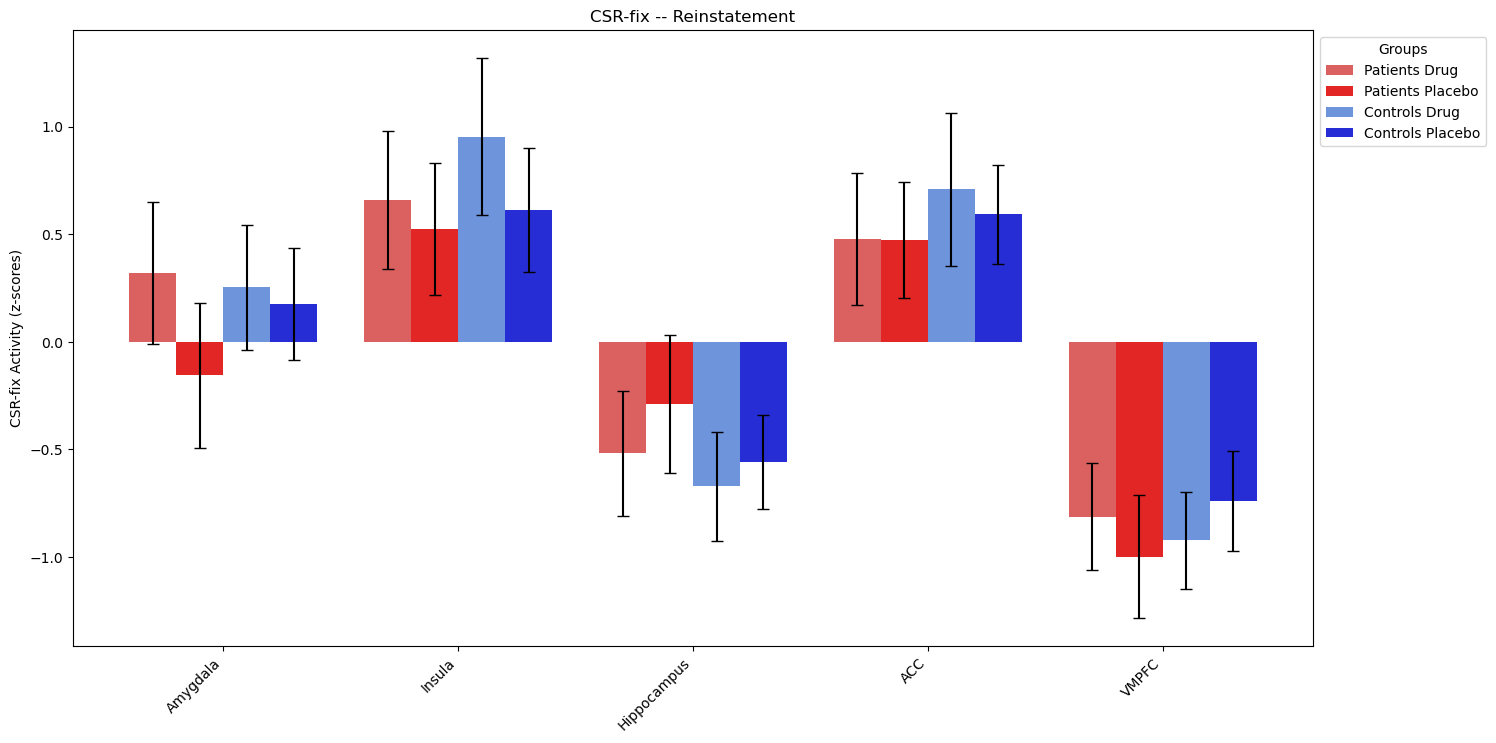

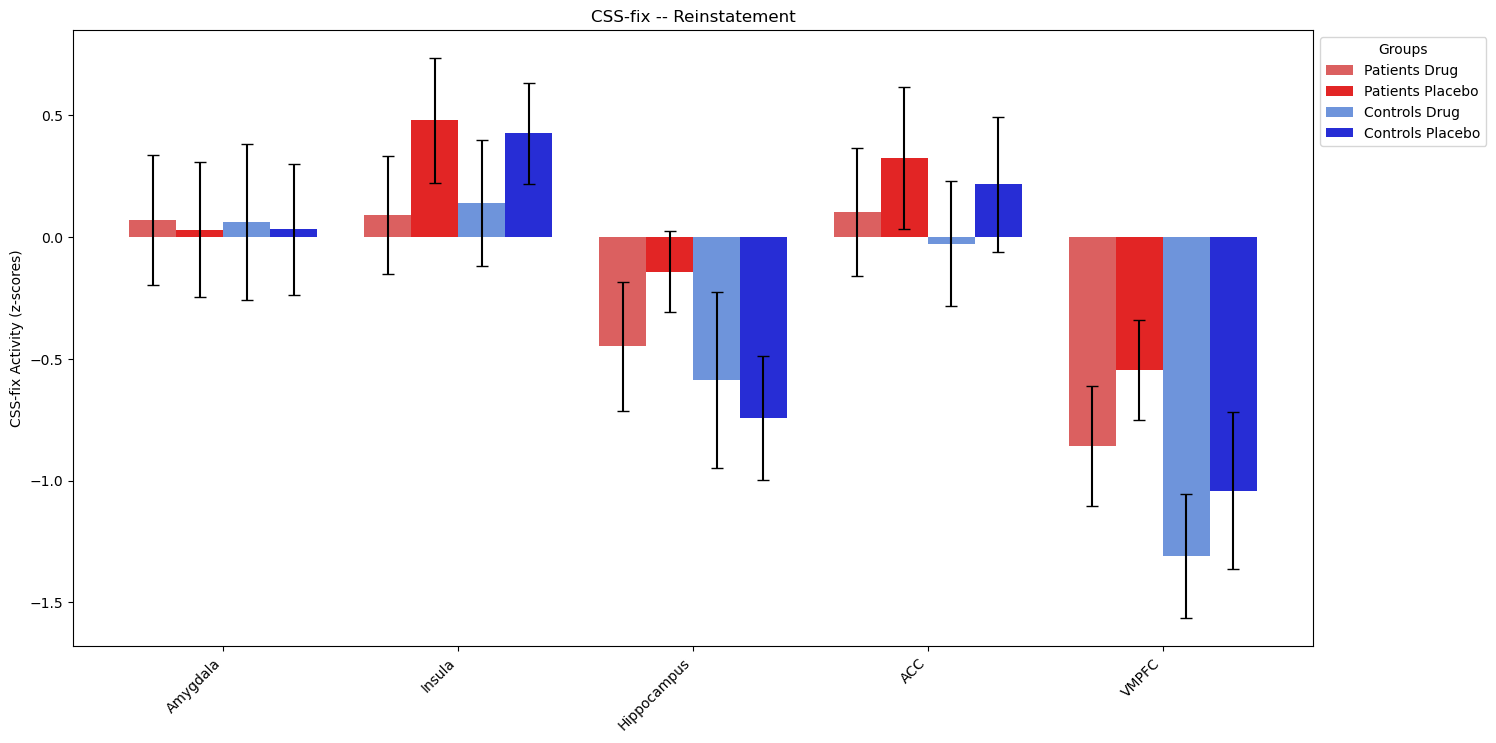

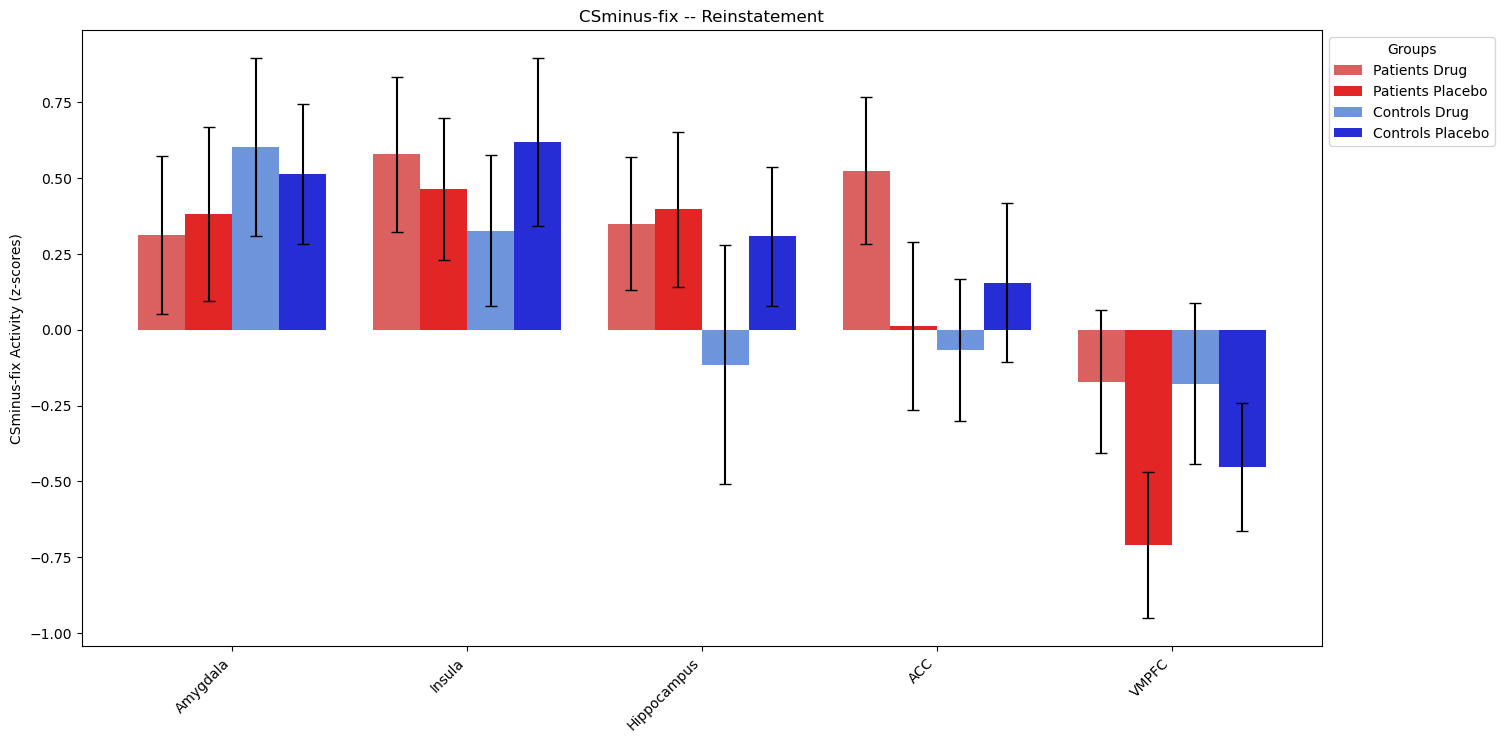

In [29]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug': group_stats(patients_drug, data),
        'patients_placebo': group_stats(patients_placebo, data),
        'controls_drug': group_stats(controls_drug, data),
        'controls_placebo': group_stats(controls_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()


# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')


In [32]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSminus-fix'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['patients_drug','patients_placebo','controls_drug','controls_placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['patients_drug'], stats['patients_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Controls Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['controls_drug'], stats['controls_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Controls Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Drug vs Controls Drug
        t_stat, p_val = ttest_ind(stats['patients_drug'], stats['controls_drug'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Drug vs Controls Drug',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Placebo vs Controls Placebo
        t_stat, p_val = ttest_ind(stats['patients_placebo'], stats['controls_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Patients Placebo vs Controls Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase3[contrast]
    region_all_data = {
        'patients_drug': extract_group_data(patients_drug, region_data, region_no),
        'patients_placebo': extract_group_data(patients_placebo, region_data, region_no),
        'controls_drug': extract_group_data(controls_drug, region_data, region_no),
        'controls_placebo': extract_group_data(controls_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,patients_drug vs. 0,1.179940,0.248708
1,Amygdala,patients_placebo vs. 0,1.297416,0.208561
2,Amygdala,controls_drug vs. 0,2.012903,0.055975
3,Amygdala,controls_placebo vs. 0,2.181336,0.038041
4,Amygdala,Patients Drug vs Placebo,-0.175362,0.861548
5,Amygdala,Controls Drug vs Placebo,0.235670,0.814651
6,Amygdala,Patients Drug vs Controls Drug,-0.728814,0.469585
7,Amygdala,Patients Placebo vs Controls Placebo,-0.354828,0.724273
8,Insula,patients_drug vs. 0,2.216959,0.035578
9,Insula,patients_placebo vs. 0,1.931777,0.066993


##### drug vs gender post-hoc

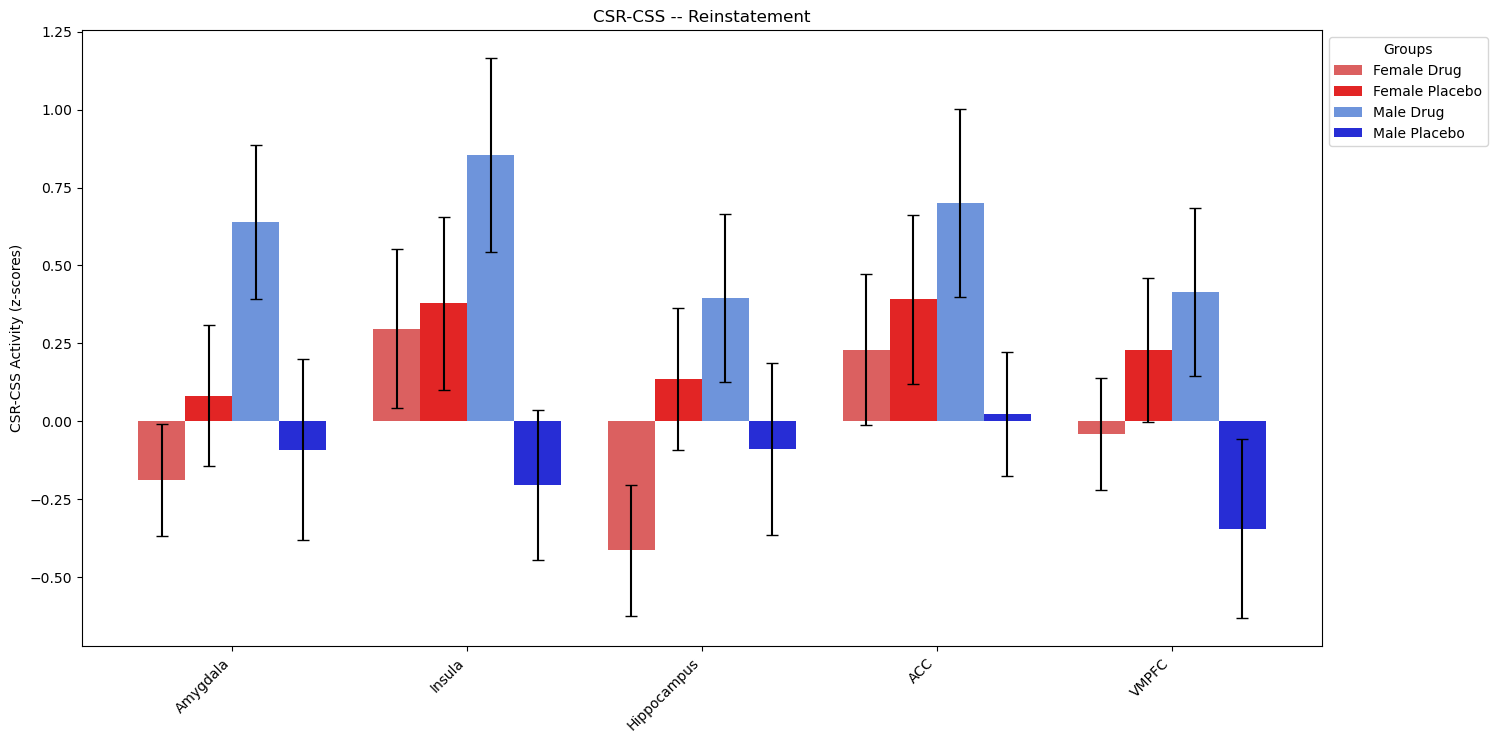

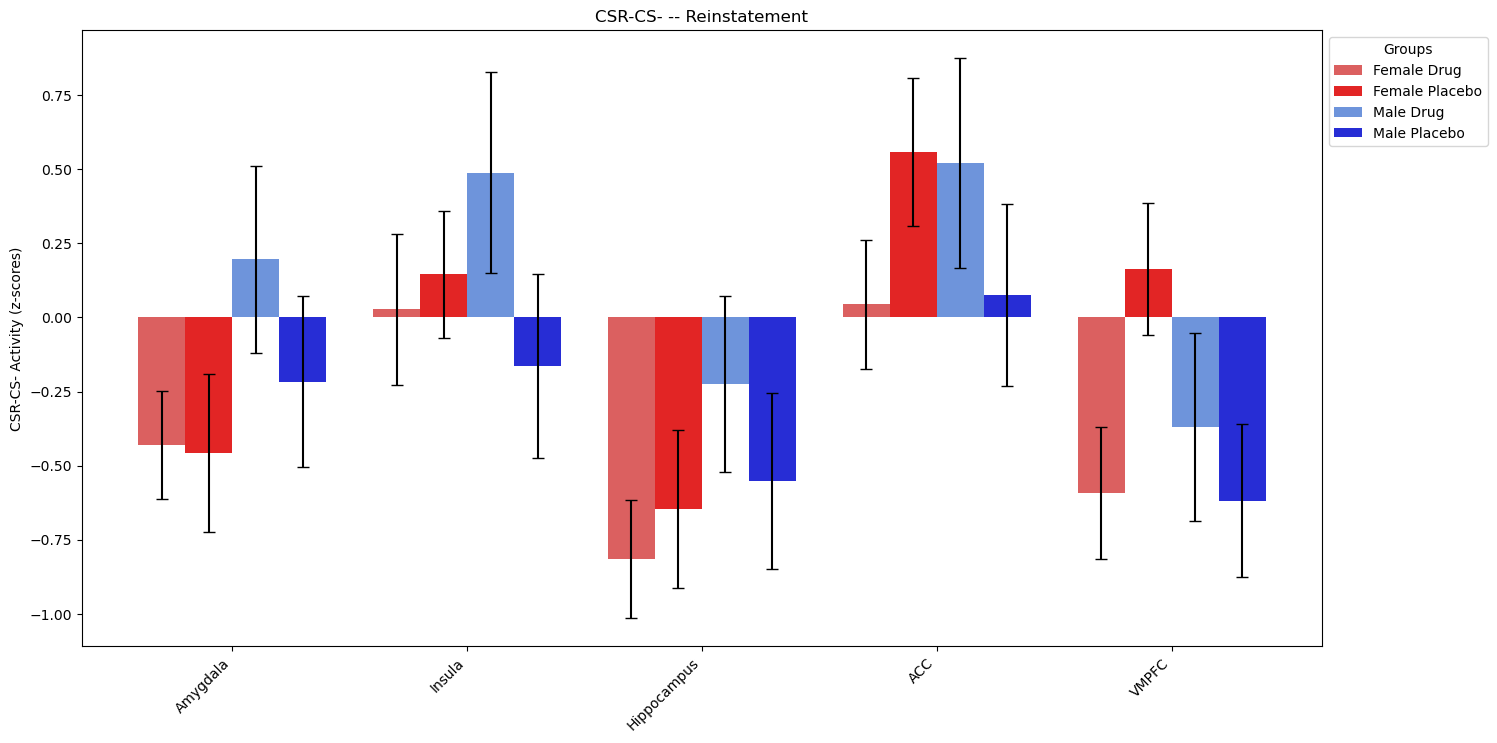

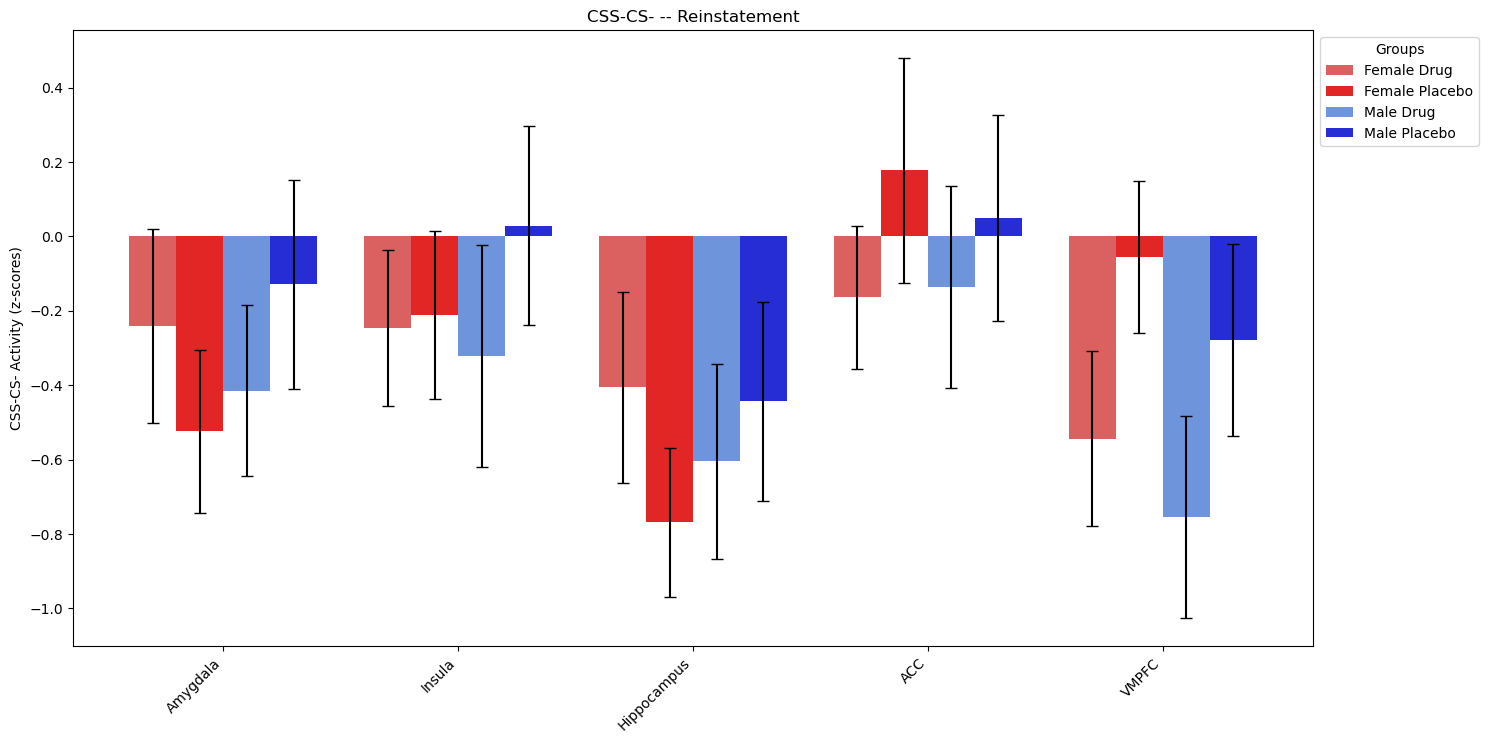

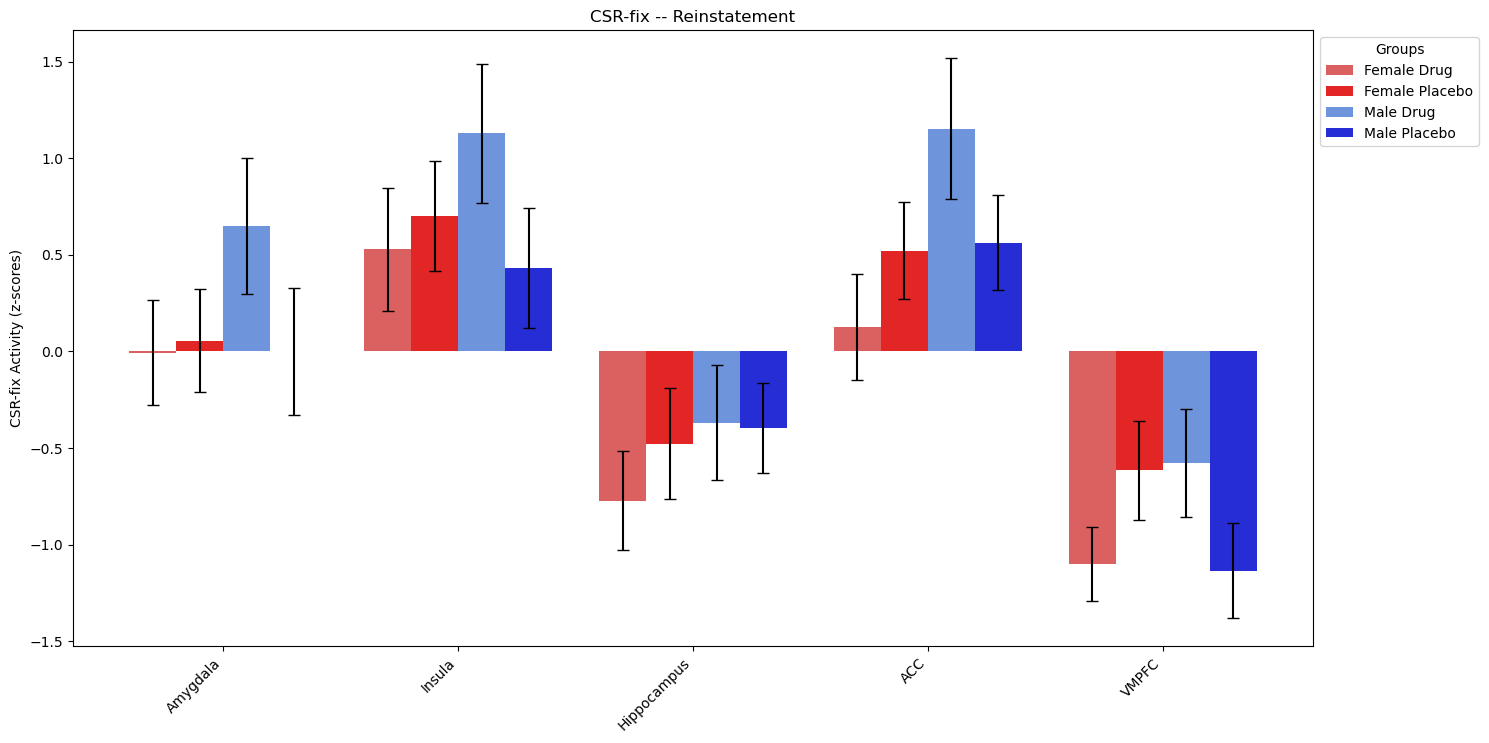

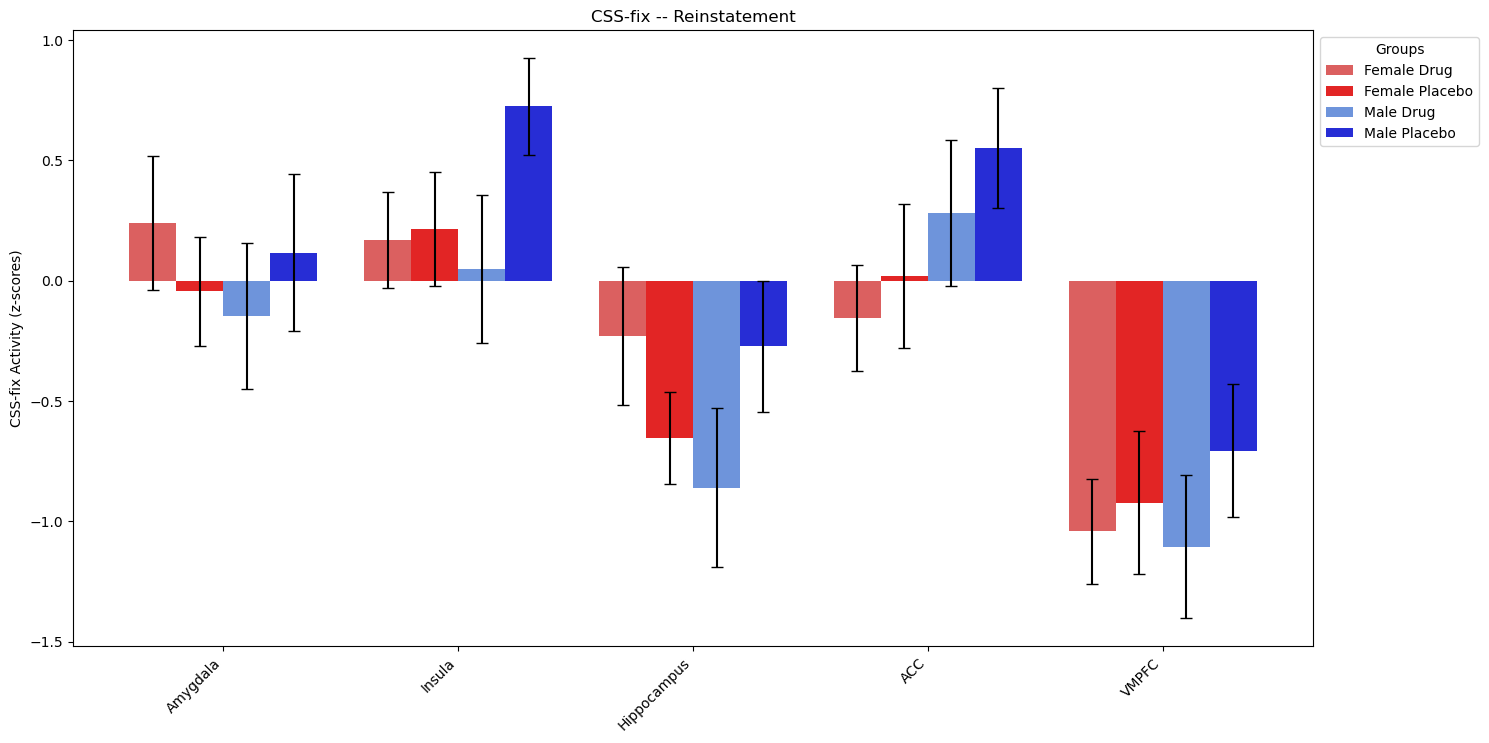

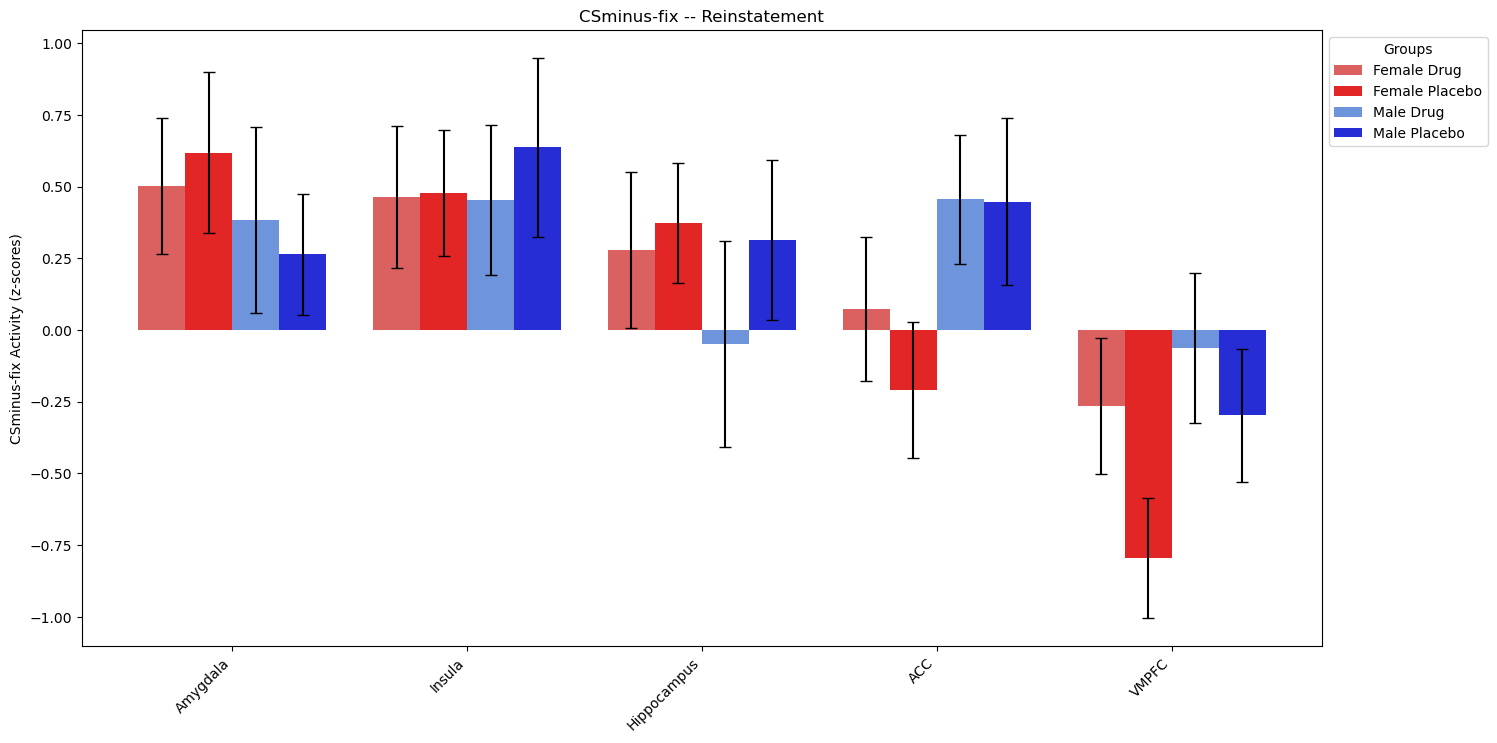

In [33]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for group in ['female_drug', 'female_placebo', 'male_drug', 'male_placebo']:
            mean, se = stats[f'{group}']
            data.append({
                'Region': region,
                'Group': group.replace('_', ' ').title(),
                'Mean': mean,
                'SE': se
            })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats(data, sub_order, region_no):
    female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'female_drug': group_stats(female_drug, data),
        'female_placebo': group_stats(female_placebo, data),
        'male_drug': group_stats(male_drug, data),
        'male_placebo': group_stats(male_placebo, data),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ["#db6060", "#e22525", "#6e94db", "#272dd5"] # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data['Mean'],
                yerr=group_data['SE'], 
                capsize=4, width=width, color=colors[i], alpha=1, label=f'{group}')
        
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'{title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()


# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CSS'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-CS-'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CS-'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-CS-_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSR-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSS-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSS-fix_vicextinction.png')

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast = 'CSminus-fix'
    region_data = file_lists_phase3[contrast]
    
    stats = extract_stats(region_data, sub_order_phase3[contrast], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title, filename='CSminus-fix_vicextinction.png')

In [41]:
from scipy.stats import ttest_ind, ttest_1samp
import pandas as pd

contrast = 'CSminus-fix'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():

        # Patients Drug vs Placebo
        groups = ['female_drug','female_placebo','male_drug','male_placebo']
        for group_name in groups:
            t_stat, p_val = ttest_1samp(stats[group_name],0)
            comparisons.append({
            'Region': region,
            'Comparison': f'{group_name} vs. 0',
            't_stat': t_stat,
            'p_val': p_val
        })

        # Patients Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['female_drug'], stats['female_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Female Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Controls Drug vs Placebo
        t_stat, p_val = ttest_ind(stats['male_drug'], stats['male_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Males Drug vs Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Drug vs Controls Drug
        t_stat, p_val = ttest_ind(stats['female_drug'], stats['male_drug'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Females Drug vs Males Drug',
            't_stat': t_stat,
            'p_val': p_val
        })
        
        # Patients Placebo vs Controls Placebo
        t_stat, p_val = ttest_ind(stats['female_placebo'], stats['male_placebo'])
        comparisons.append({
            'Region': region,
            'Comparison': f'Female Placebo vs Male Placebo',
            't_stat': t_stat,
            'p_val': p_val
        })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    female_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[1] == 1 and drug_order.loc[sub[3:7]].values[3] == 0]    
    female_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 0 and drug_order.loc[sub[3:7]].values[1] == 0]
    male_drug = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 1]
    male_placebo = [sub for sub in sub_order if drug_order.loc[sub[3:7]].values[3] == 1 and drug_order.loc[sub[3:7]].values[1] == 0]
    return female_drug, female_placebo, male_drug, male_placebo

# Retrieve groups by calling the function
female_drug, female_placebo, male_drug, male_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data = file_lists_phase3[contrast]
    region_all_data = {
        'female_drug': extract_group_data(female_drug, region_data, region_no),
        'female_placebo': extract_group_data(female_placebo, region_data, region_no),
        'male_drug': extract_group_data(male_drug, region_data, region_no),
        'male_placebo': extract_group_data(male_placebo, region_data, region_no),
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,female_drug vs. 0,2.085922,0.046565
1,Amygdala,female_placebo vs. 0,2.169074,0.039407
2,Amygdala,male_drug vs. 0,1.156020,0.260073
3,Amygdala,male_placebo vs. 0,1.227087,0.232760
4,Amygdala,Female Drug vs Placebo,-0.312188,0.756123
5,Amygdala,Males Drug vs Placebo,0.302021,0.764059
6,Amygdala,Females Drug vs Males Drug,0.298178,0.766828
7,Amygdala,Female Placebo vs Male Placebo,0.966184,0.338795
8,Insula,female_drug vs. 0,1.849547,0.075354
9,Insula,female_placebo vs. 0,2.121371,0.043584


## Early vs late

### First Level

In [10]:
# removing subjects w wrong sequence / missing phases: 
subjects = layout.get_subjects()
subjects1 = subjects
del(subjects1[0]) #sub101 has 2mm seq for phase 2, 3mm (correct) for phase 3
del(subjects1[49]) # sub201, has 2mm seq for phase 2, 3mm (correct) for phase 3 

subjects = layout.get_subjects()
subjects2 = subjects
del(subjects2[15]) #sub 120 missing phase 3

subjects = layout.get_subjects()

In [11]:
# can load in onsets (events.tsv) for all subs here as all subs have same task timings 
onsets_phase2 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT.xlsx',sheet_name=0)
onsets_phase3 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT.xlsx',sheet_name=1)
onsets_phase3_sub202 = pd.read_excel('/Volumes/Seagate Desktop Drive/NARSAD/task-Narsad_events-SPLIT.xlsx',sheet_name=2)

onsets = onsets_phase2, onsets_phase3
onsets_sub202 = onsets_phase2, onsets_phase3_sub202

def load_bids_events(layout,onsets, subject, task, phaseno):
    '''Create a design_matrix instance from BIDS event file'''
    
    tr = layout.get_tr()
    # change lines below -- can change to "mask", change task to "self-other"
    func_files = layout.get(subject=subject,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
    func_file = nimg.load_img(func_files)
    n_tr = func_file.shape[-1]
    onsets=onsets[phaseno]
    #onsets = pd.read_csv(layout_raw.get(subject=subject, suffix='events')[run].path, sep='\t') -- line to use if events changes by 
    
    # line below is isolating the onset, duration, and trial type columns -- change according to events.tsv format 
    onsets_actual = onsets.iloc[:, [0,1,3]]
    onsets_actual.columns = ['onset', 'duration','trial_type'] # make sure this order matches with what's loaded in as onsets 
    sampling_freq = 1/tr
    n_scans=n_tr
    return onsets_actual, tr, n_scans

In [12]:
# to iterate through subjects ... 
#for sub in subjects 
from scipy.stats import norm

p001_unc = norm.isf(0.001)

file_lists_phase2 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

file_lists_phase3 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

sub_order_phase2 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

sub_order_phase3 = {
        "CSRearly-CSSearly": list(),   
        "CSRearly-CS-early": list(),
        "CSSearly-CS-early": list(),
        "CSRearly-fixearly": list(), 
        "CSSearly-fixearly": list(),   
        "CSminusearly-fixearly": list(),
        "CSRlate-CSSlate": list(), 
        "CSRlate-CS-late": list(),   
        "CSSlate-CS-late": list(),
        "CSRlate-fixlate": list(),
        "CSSlate-fixlate": list(),   
        "CSminuslate-fixlate": list()
        }

tasks = ['phase2','phase3']

for phaseno, task in enumerate(tasks): 

    if task == 'phase2':
        subject_list = subjects1 
    elif task == 'phase3':
        subject_list = subjects2        
    
    for sub in subject_list: 

        fmri_imgs = layout.get(subject=sub,
                        datatype='func', task=task,
                        desc='preproc',
                        space='MNI152NLin2009cAsym',
                        extension='nii.gz',
                       return_type='file')
        hrf_model = "spm" #canonical hrf 
        high_pass = 0.01 # The cutoff for the drift model is 0.01 Hz.

        dmn_time_series = []
        for con_img in fmri_imgs:
            dmn_time_series.append(masker.fit_transform(con_img))
        dmn_time_series = np.concatenate(dmn_time_series, axis = 0)
        
        confound_files = layout.get(subject=sub,
                            datatype='func', task=task,
                            desc='confounds',
                           extension="tsv",
                           return_type='file')
        # Select confounds 
        confound_vars = ['trans_x','trans_x_derivative1','trans_x_derivative1_power2','trans_x_power2',
                           'trans_y','trans_y_derivative1','trans_y_derivative1_power2','trans_y_power2',
                             'trans_z','trans_z_derivative1','trans_z_derivative1_power2','trans_z_power2',
                             'rot_x','rot_x_derivative1','rot_x_derivative1_power2','rot_x_power2',
                             'rot_y','rot_y_derivative1','rot_y_derivative1_power2','rot_y_power2',
                             'rot_z','rot_z_derivative1','rot_z_derivative1_power2','rot_z_power2',
                             'csf','csf_derivative1','csf_derivative1_power2','csf_power2',
                             'white_matter','white_matter_derivative1','white_matter_derivative1_power2','white_matter_power2'
                        ]

        final_confounds = confound_vars

        design_matrices = []

        print("Creating First Level Design matrix ... ")

        if sub == 'N202':
            onsets_file = onsets_sub202 
        else:
            onsets_file = onsets
        
        for img in enumerate(fmri_imgs):
    # Build experimental paradigm
            events,tr,n_scans = load_bids_events(layout,onsets_file, sub, task, phaseno)
        # Define the sampling times for the design matrix
            frame_times = np.arange(n_scans) * tr
            confound_file = confound_files[0]
            confound_df = pd.read_csv(confound_file, delimiter='\t')
            confound_df = confound_df[final_confounds]
            confound_df.fillna(0, inplace=True)            
        # Build design matrix with the previously defined parameters
            design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model=hrf_model,
                drift_model="polynomial",
                drift_order=3,
                add_regs=confound_df,
                add_reg_names=confound_vars,
                high_pass=high_pass,
            )

        design_matrices.append(design_matrix)
        design_matrix_allruns = []    
        design_matrix_allruns = np.concatenate(design_matrices, axis = 0)
            
        contrast_matrix = []
        contrast_matrix = np.eye(design_matrix.shape[1])
        basic_contrasts = {
            column: contrast_matrix[i]
            for i, column in enumerate(design_matrix.columns)
        }
        
        contrasts = {
            "CSRearly-CSSearly": (basic_contrasts["CSR-early"] - basic_contrasts["CSS-early"]),   
            "CSRearly-CS-early": (basic_contrasts["CSR-early"] - basic_contrasts["CS--early"]),   
            "CSSearly-CS-early": (basic_contrasts["CSS-early"] - basic_contrasts["CS--early"]), 
            "CSRearly-fixearly": (basic_contrasts["CSR-early"] - basic_contrasts["FIXATION-early"]),   
            "CSSearly-fixearly": (basic_contrasts["CSS-early"] - basic_contrasts["FIXATION-early"]),   
            "CSminusearly-fixearly": (basic_contrasts["CS--early"] - basic_contrasts["FIXATION-early"]),
            "CSRlate-CSSlate": (basic_contrasts["CSR-late"] - basic_contrasts["CSS-late"]),   
            "CSRlate-CS-late": (basic_contrasts["CSR-late"] - basic_contrasts["CS--late"]),   
            "CSSlate-CS-late": (basic_contrasts["CSS-late"] - basic_contrasts["CS--late"]), 
            "CSRlate-fixlate": (basic_contrasts["CSR-late"] - basic_contrasts["FIXATION-late"]),   
            "CSSlate-fixlate": (basic_contrasts["CSS-late"] - basic_contrasts["FIXATION-late"]),   
            "CSminuslate-fixlate": (basic_contrasts["CS--late"] - basic_contrasts["FIXATION-late"]), 
        }

    #fmri_glm = FirstLevelModel()
        labels, estimates = run_glm(dmn_time_series, design_matrix_allruns)

        for contrast_id, contrast_val in contrasts.items():
            contrast = compute_contrast(labels, estimates, contrast_val)
            z_score = contrast.z_score()
            print(f"{contrast_id}: Z-score outputs: {z_score}")

            # Ensure subject data is appended properly
            if phaseno == 0:  # phase2
                file_lists_phase2[contrast_id].append(contrast)
                sub_order_phase2[contrast_id].append(f'sub{sub}-ses{task}')            
            else:  # phase3
                file_lists_phase3[contrast_id].append(contrast)
                sub_order_phase3[contrast_id].append(f'sub{sub}-ses{task}')

        print(f"Subject {sub} completed for {task}!")

    

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Create an Excel writer object
with pd.ExcelWriter('phase3_data.xlsx') as writer:
    for contrast in file_lists_phase3.keys():  # Loop through each contrast
        contrast_list = file_lists_phase3[contrast]  # List of contrast objects (one per subject)

        # Dictionary to store z-scores for each region
        data_dict = {region: [] for region in regions_of_interest}

        # Loop through each subject's contrast object
        for subject_contrast in contrast_list:
            z_scores = subject_contrast.z_score()  # Extract z-scores
            
            # Append z-scores to the corresponding region
            for region_no, region in enumerate(regions_of_interest):
                data_dict[region].append(z_scores[region_no])  # Store each subject's z-score

        # Convert to a DataFrame (rows = subjects, columns = regions)
        df = pd.DataFrame(data_dict)

        # Save to a new sheet in the Excel file
        df.to_excel(writer, sheet_name=contrast, index=False)

print("Excel file with z-scores saved successfully!")


Excel file with z-scores saved successfully!


### Extinction 

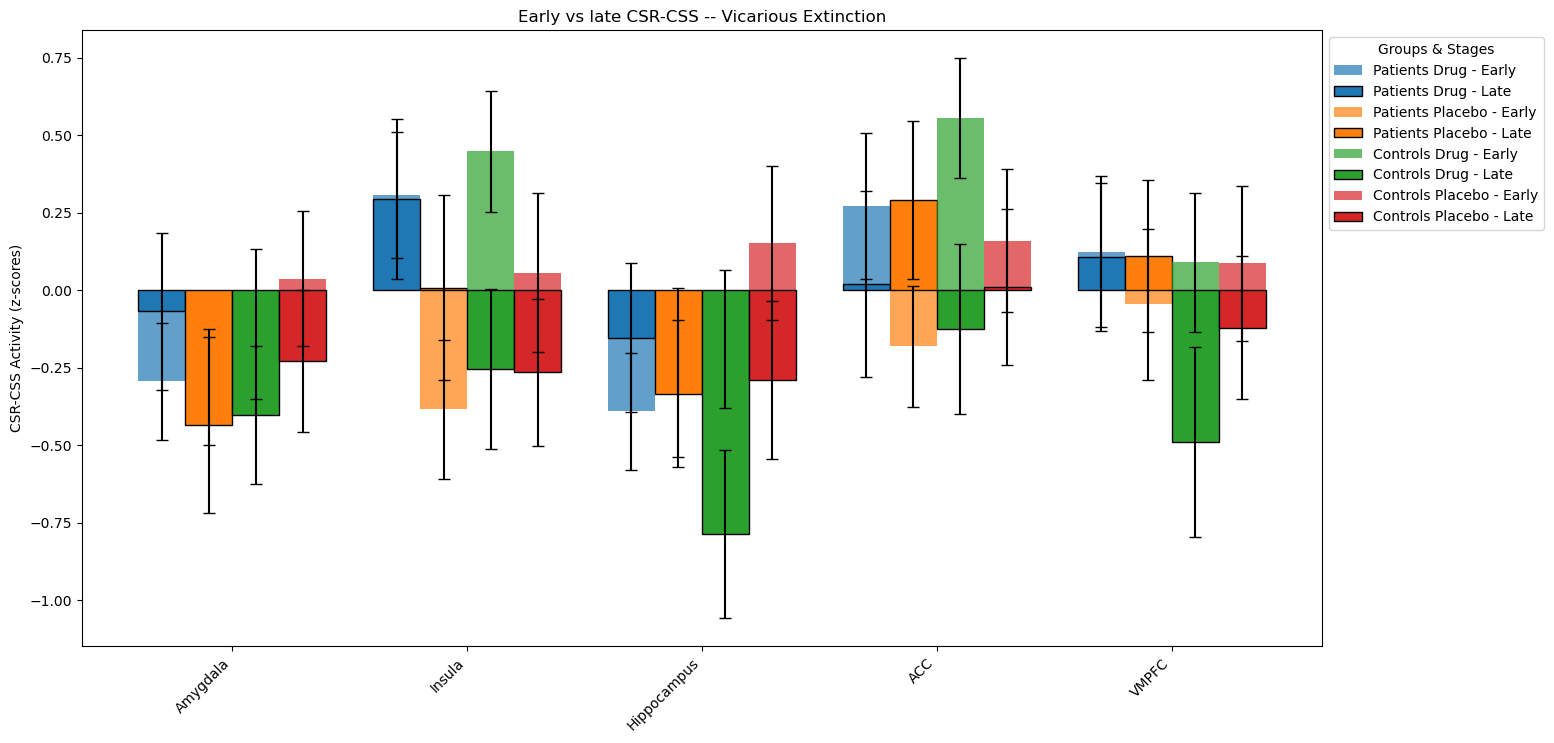

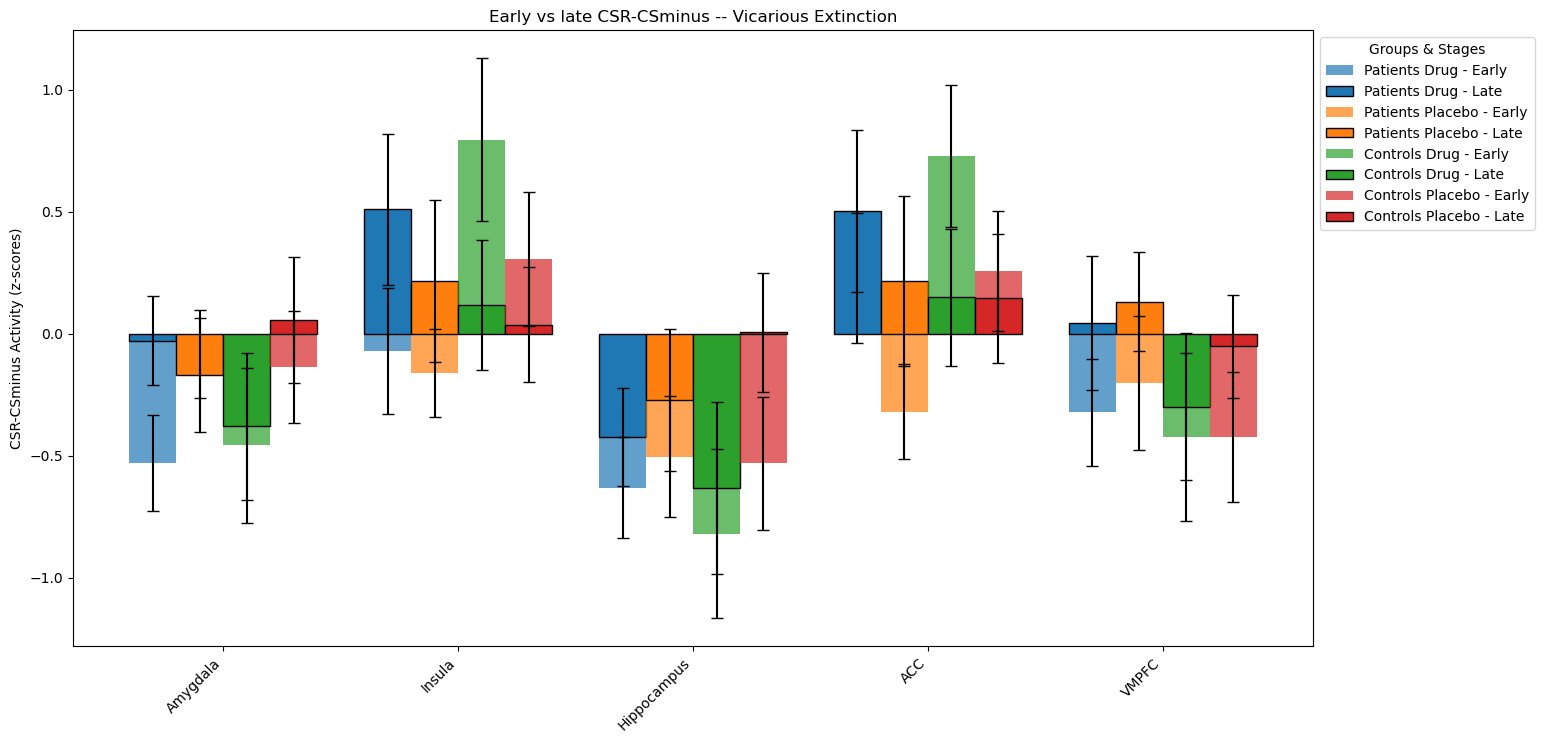

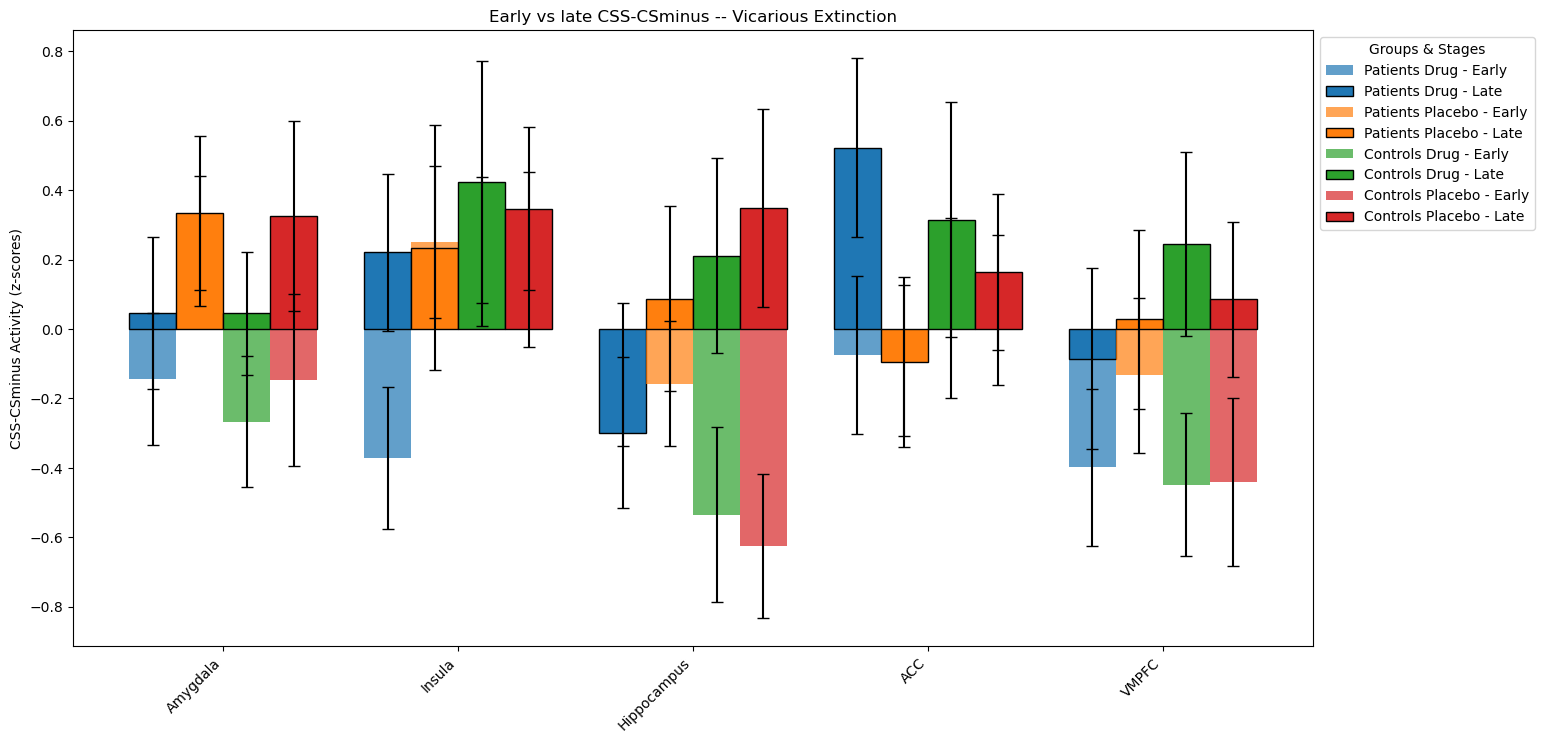

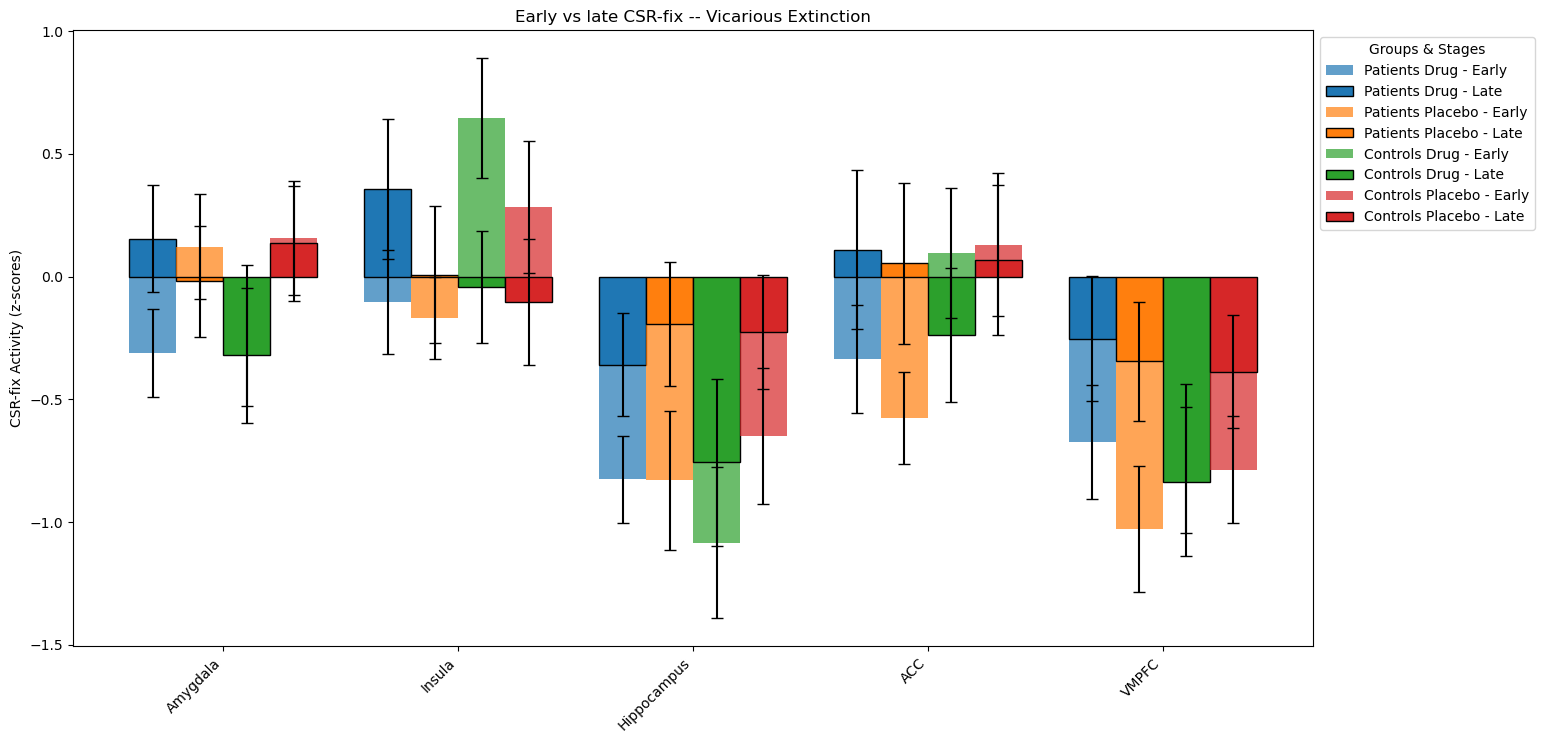

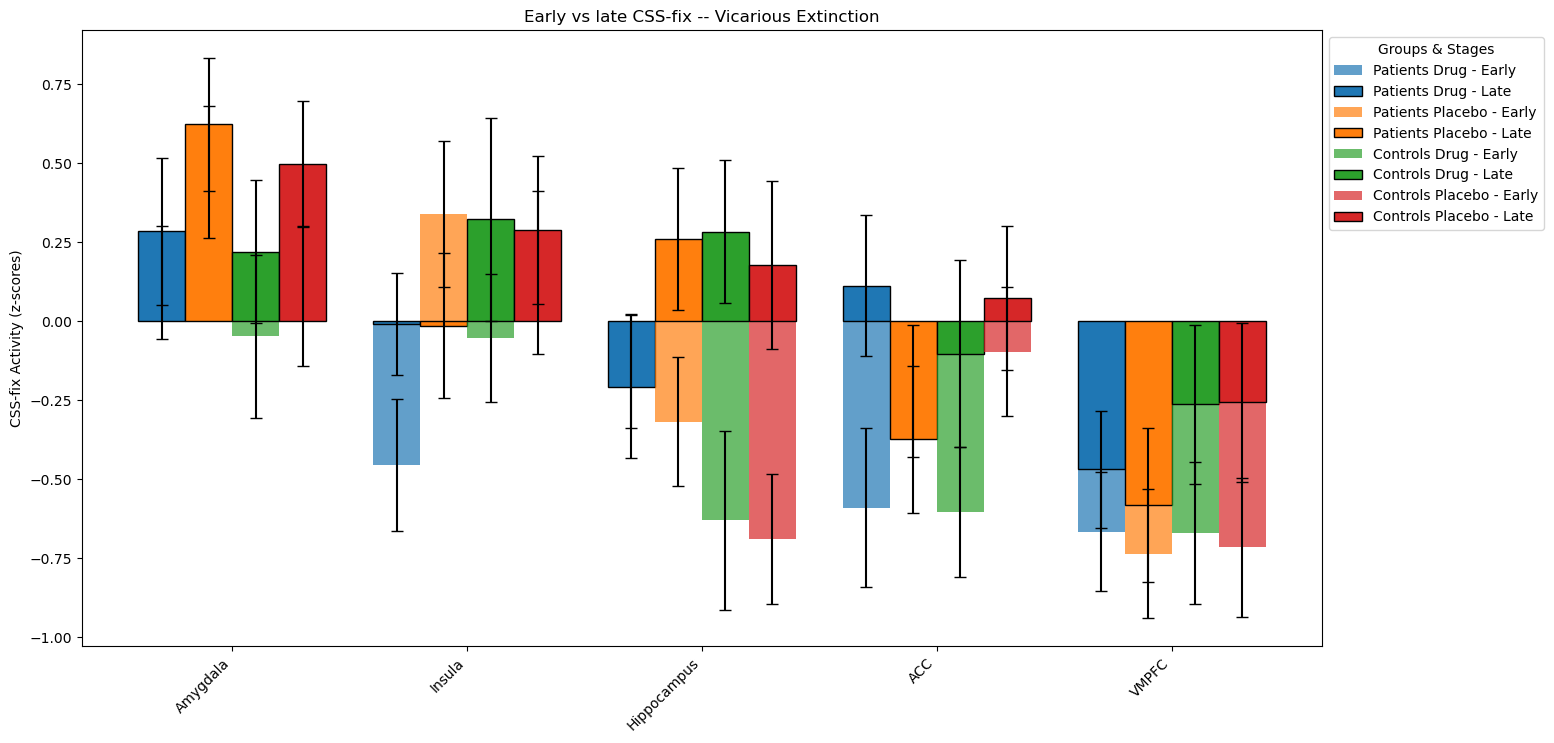

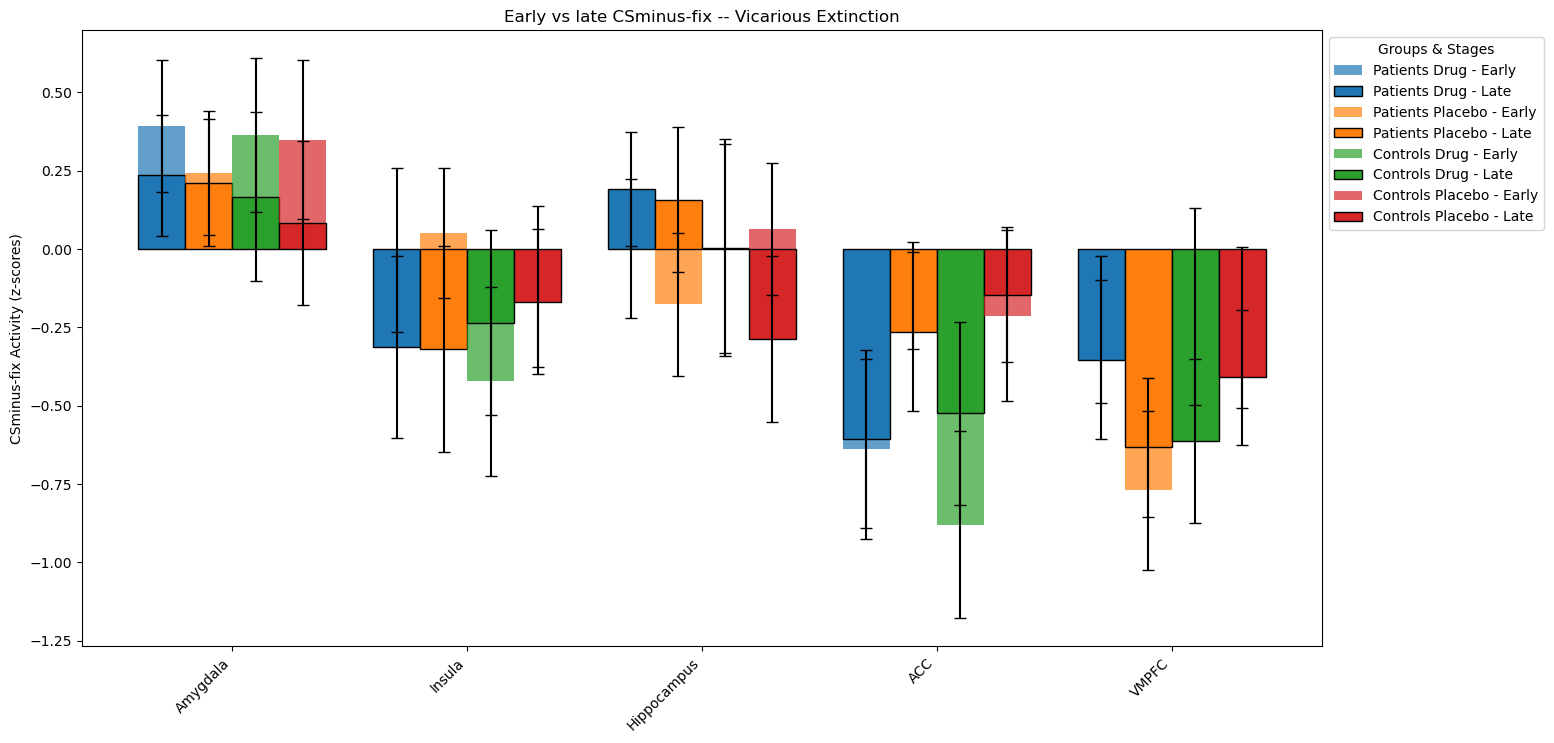

In [ ]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs late {title} -- Vicarious Extinction')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CS-early'
    contrast_late = 'CSRlate-CS-late'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-CSminus_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-CS-early'
    contrast_late = 'CSSlate-CS-late'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-CSminus_vicextinction.png')


all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-fixearly'
    contrast_late = 'CSRlate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-fix_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-fixearly'
    contrast_late = 'CSSlate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-fix_vicextinction.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSminusearly-fixearly'
    contrast_late = 'CSminuslate-fixlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSminus-fix_vicextinction.png')


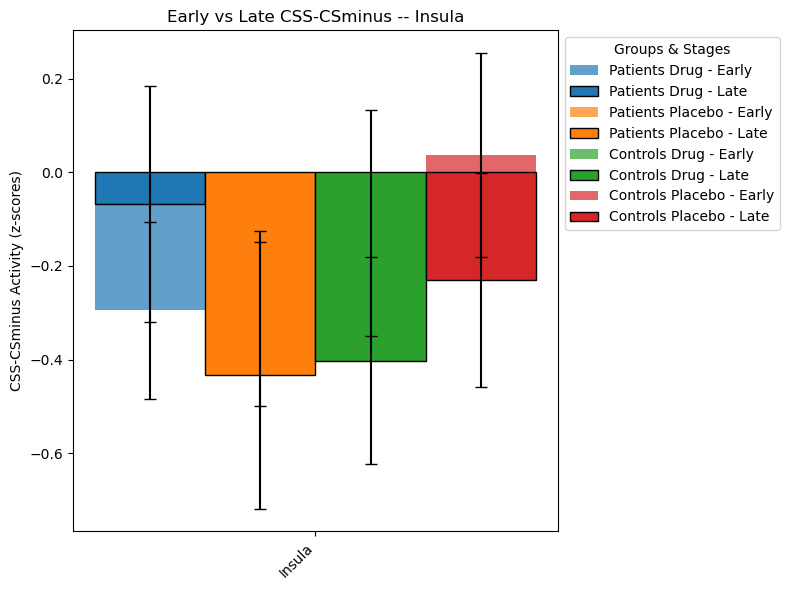

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)

# Define only Insula as the region of interest
regions_of_interest = ['Insula']

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for Insula only with error bars
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(8, 6))  # Adjusted size for single region plot
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each stage (Early and Late) as grouped bars with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for Insula
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Insula')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
region_no = regions_of_interest.index('Insula')
region = 'Insula'
contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'
region_data_early = file_lists_phase2[contrast_early]
region_data_late = file_lists_phase2[contrast_late]

stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
all_stats[region] = stats

# Plot the multibar plot for Insula only
plot_multibar_with_error_bars(all_stats, title, filename=f'{title}_Insula_vicextinction.png')


In [ ]:
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]
regions_of_interest.index('Insula')

1

In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]


contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase2, contrast_early, regions_of_interest, sub_order_phase2)
late_data = extract_contrast_data(file_lists_phase2, contrast_late, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for time, y in zip(time_values, values):
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'Time': time,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(early_data, late_data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup * Time + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.018
Method:                 Least Squares   F-statistic:                    0.5678
Date:                Tue, 12 Nov 2024   Prob (F-statistic):              0.803
Time:                        12:39:47   Log-Likelihood:                -310.82
No. Observations:                 200   AIC:                             639.6
Df Residuals:                     191   BIC:                             669.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each group
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages
        for stage in ['early', 'late']:
            # Patients Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['patients_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Controls Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['controls_drug'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Controls Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Drug vs Controls Drug
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['controls_drug'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Controls Drug ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase2[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase2['CSRearly-CSSearly']
    region_data_late = file_lists_phase2['CSRlate-CSSlate']
    region_all_data = {
        'patients_drug': {'early': extract_group_data(patients_drug, region_data_early, region_no),
                          'late': extract_group_data(patients_drug, region_data_late, region_no)},
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_drug': {'early': extract_group_data(controls_drug, region_data_early, region_no),
                          'late': extract_group_data(controls_drug, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Drug Early vs Late,-0.703573,0.484837
1,Amygdala,Patients Placebo Early vs Late,0.349061,0.728788
2,Amygdala,Controls Drug Early vs Late,0.880961,0.382919
3,Amygdala,Controls Placebo Early vs Late,0.826673,0.412200
4,Amygdala,Patients Drug vs Placebo (Early),0.065690,0.947903
5,Amygdala,Controls Drug vs Placebo (Early),-0.435920,0.664810
6,Amygdala,Patients Drug vs Controls Drug (Early),-0.602415,0.549676
7,Amygdala,Patients Placebo vs Controls Placebo (Early),-1.160904,0.251543
8,Amygdala,Patients Drug vs Placebo (Late),0.943394,0.350304
9,Amygdala,Controls Drug vs Placebo (Late),-0.529953,0.598538


#### placebo only! 

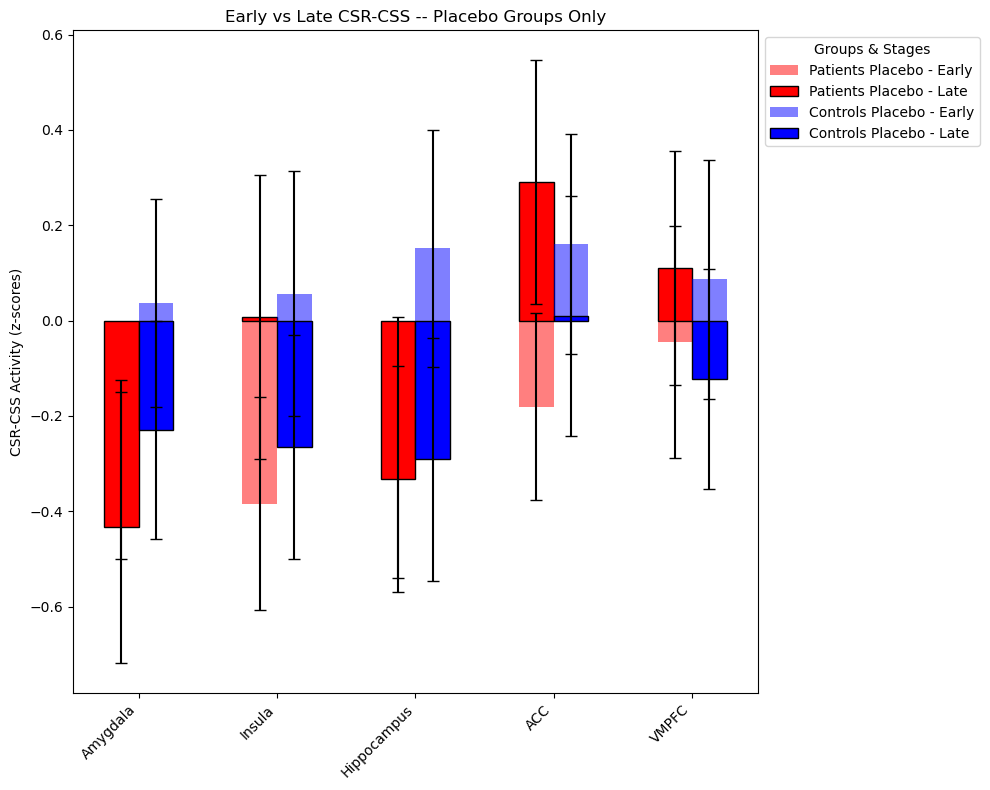

In [ ]:
### just placebo ! 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare data for multibar plot with error bars, only for placebo groups
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_placebo', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts, only for placebo groups
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    _, patients_placebo, _, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each placebo group for both early and late contrasts
    stats = {
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    groups = df['Group'].unique()
    colors = ['red', 'blue']  # Colors for each placebo group

    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.25  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.5, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 0.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Placebo Groups Only')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase2[contrast_early]
    region_data_late = file_lists_phase2[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions for placebo condition only
title = 'CSR-CSS'
filename = 'CSR-CSS_placebo_vicext_ROIs_combined.png'
plot_multibar_with_error_bars(all_stats, title,filename)

# for region_no, region in enumerate(regions_of_interest):
#     contrast_early = 'CSRearly-CS-early'
#     contrast_late = 'CSRlate-CS-late'
#     region_data_early = file_lists_phase2[contrast_early]
#     region_data_late = file_lists_phase2[contrast_late]
    
#     stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
#     all_stats[region] = stats

# # Plot combined multibar plot across all regions for placebo condition only
# title = 'CSR-CS-'
# plot_multibar_with_error_bars(all_stats, title, filename)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx, sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase2, contrast_early, regions_of_interest, sub_order_phase2)
late_data = extract_contrast_data(file_lists_phase2, contrast_late, regions_of_interest, sub_order_phase2)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            
            # Only include placebo subjects
            if drug_order == 0:
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                gender = drug_order_df.loc[subID].values[3]  # Gender coding
                
                for time, y in zip(time_values, values):
                    data.append({
                        'Subject': subID,
                        'Region': region,
                        'y': y,
                        'Time': time,
                        'PatientGroup': patient_group,
                        'Gender': gender
                    })
    
    return pd.DataFrame(data)

# Prepare the regression data for placebo only
df = prepare_regression_data(early_data, late_data, sub_order_phase2, drug_order_df)

# Loop through each region, run the model without DrugOrder, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model without DrugOrder
    model = smf.ols('y ~ PatientGroup * Time', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                    0.7237
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.540
Time:                        16:21:56   Log-Likelihood:                -152.49
No. Observations:                  98   AIC:                             313.0
Df Residuals:                      94   BIC:                             323.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table (only placebo groups)
def perform_posthoc_tests_placebo(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each placebo group
        for group in ['patients_placebo', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages for placebo groups
        for stage in ['early', 'late']:
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase2[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects, keeping only placebo groups
def separate_groups_by_placebo(sub_order, drug_order):
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_placebo, controls_placebo

# Retrieve placebo groups by calling the function
patients_placebo, controls_placebo = separate_groups_by_placebo(sub_order_phase2[contrast], drug_order_df)

# Populate all_data with actual values for placebo groups
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase2['CSRearly-CSSearly']
    region_data_late = file_lists_phase2['CSRlate-CSSlate']
    region_all_data = {
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table (placebo only)
summary_table = perform_posthoc_tests_placebo(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Placebo Early vs Late,0.349061,0.728788
1,Amygdala,Controls Placebo Early vs Late,0.826673,0.412200
2,Amygdala,Patients Placebo vs Controls Placebo (Early),-1.160904,0.251543
3,Amygdala,Patients Placebo vs Controls Placebo (Late),-0.554807,0.581658
4,Insula,Patients Placebo Early vs Late,-1.029697,0.309046
5,Insula,Controls Placebo Early vs Late,0.906388,0.368912
6,Insula,Patients Placebo vs Controls Placebo (Early),-1.238171,0.221802
7,Insula,Patients Placebo vs Controls Placebo (Late),0.714789,0.478275
8,Hippocampus,Patients Placebo Early vs Late,0.181913,0.856526
9,Hippocampus,Controls Placebo Early vs Late,1.221607,0.227366


### Reinstatement

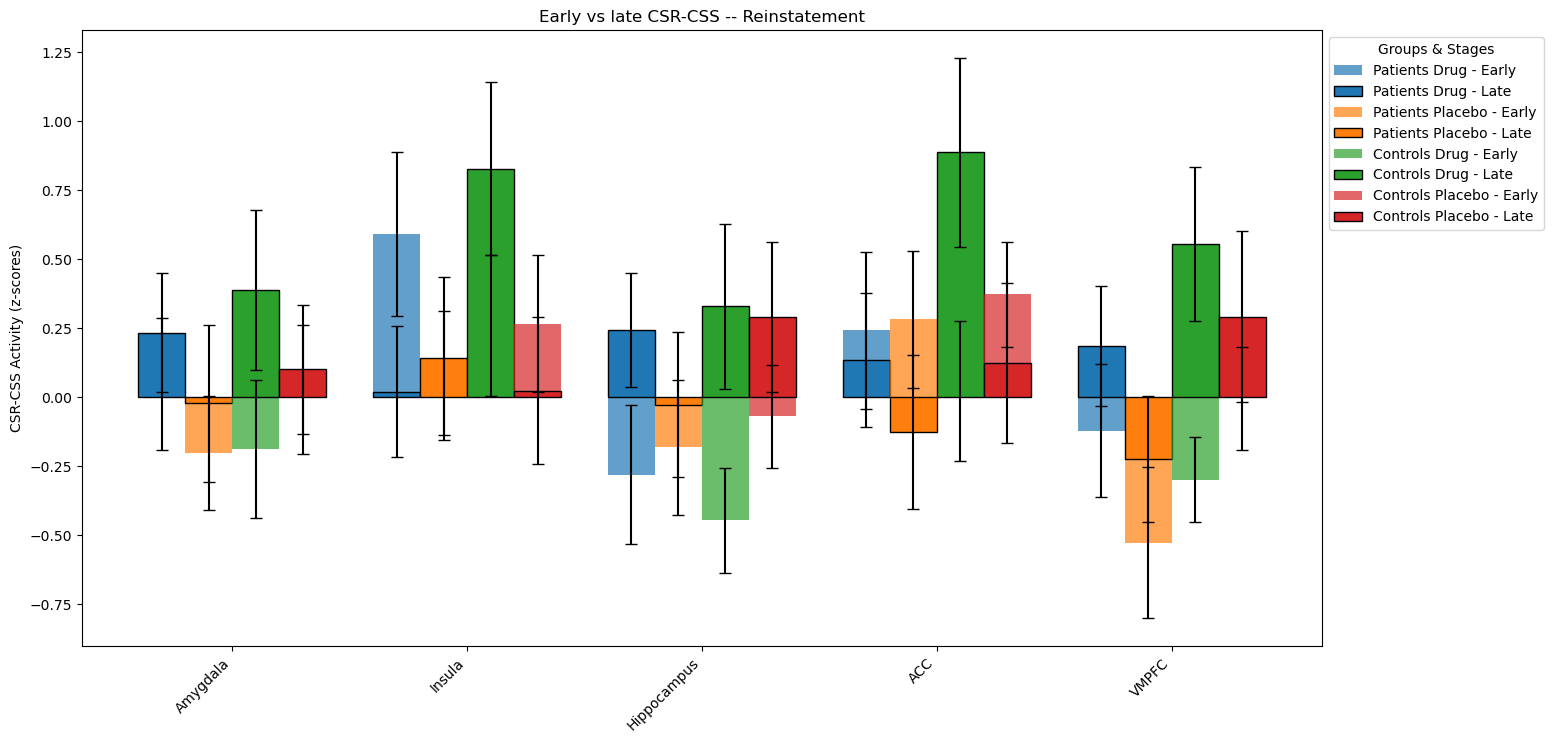

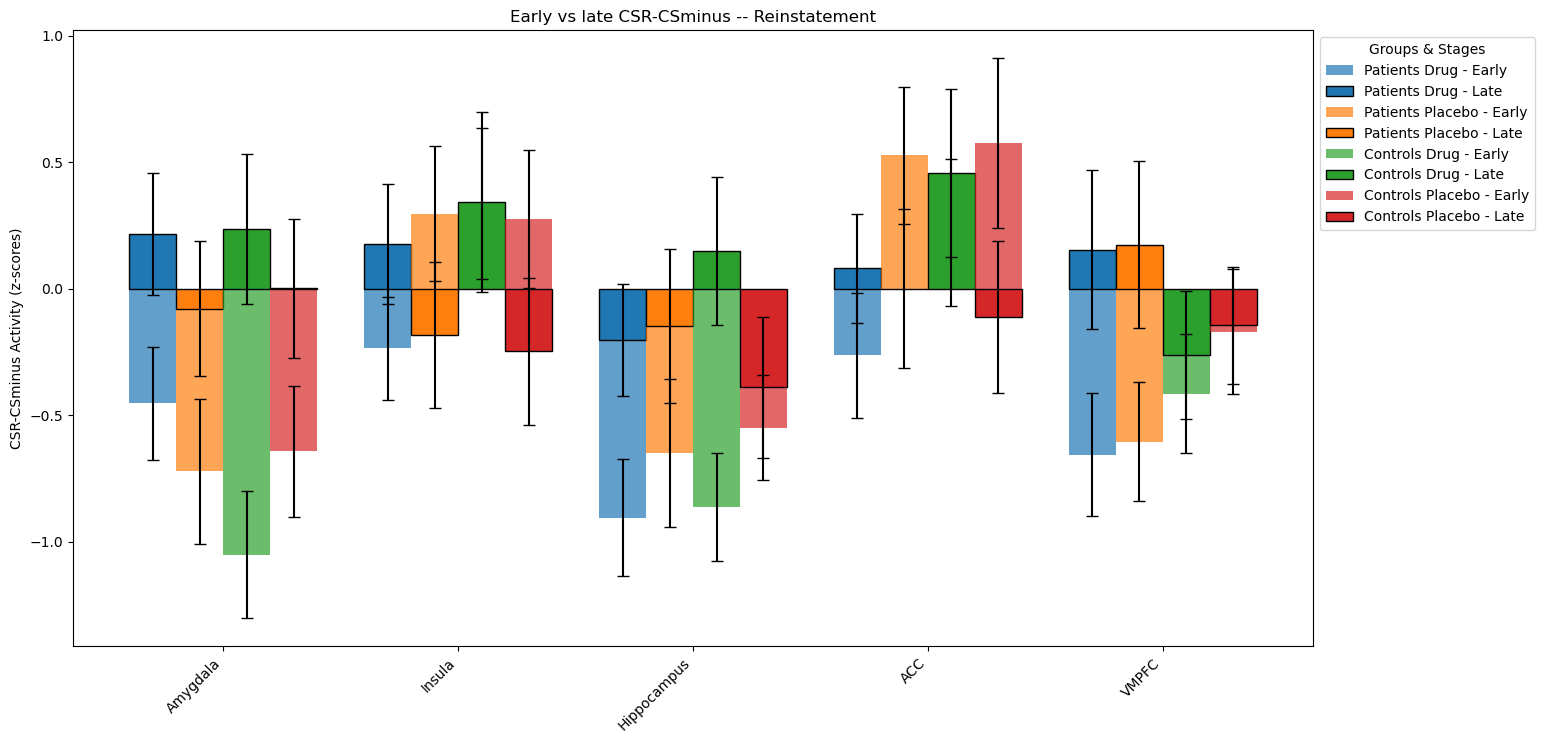

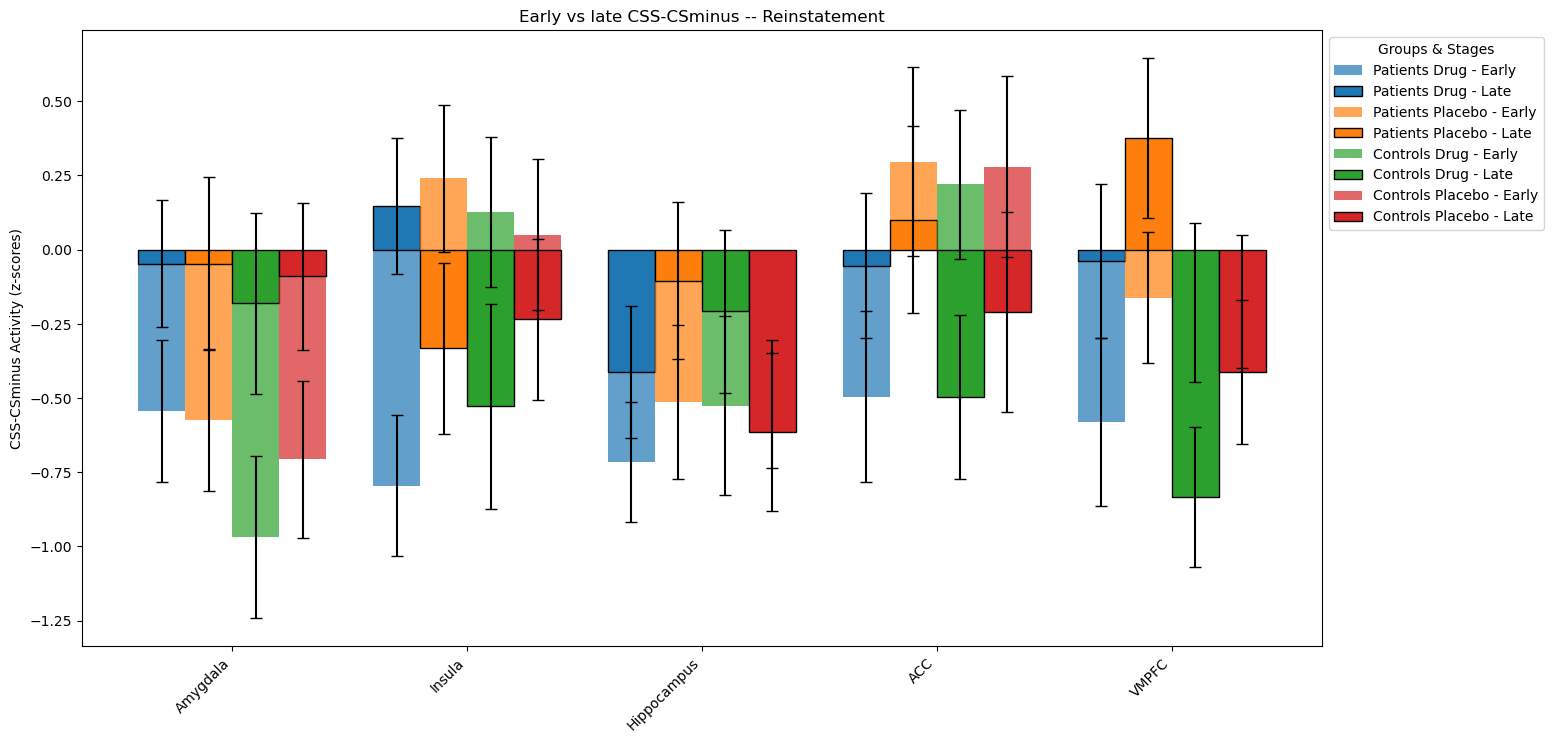

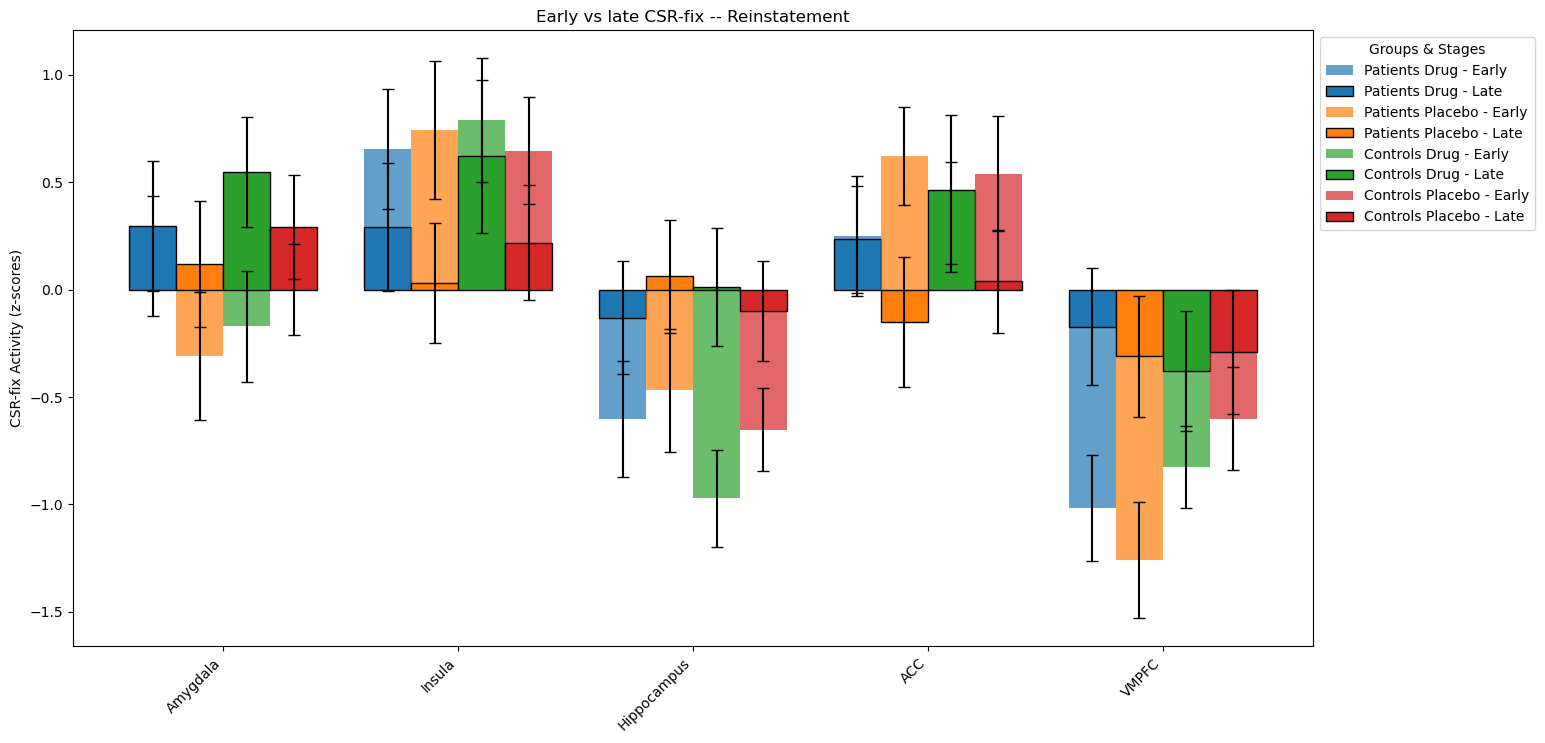

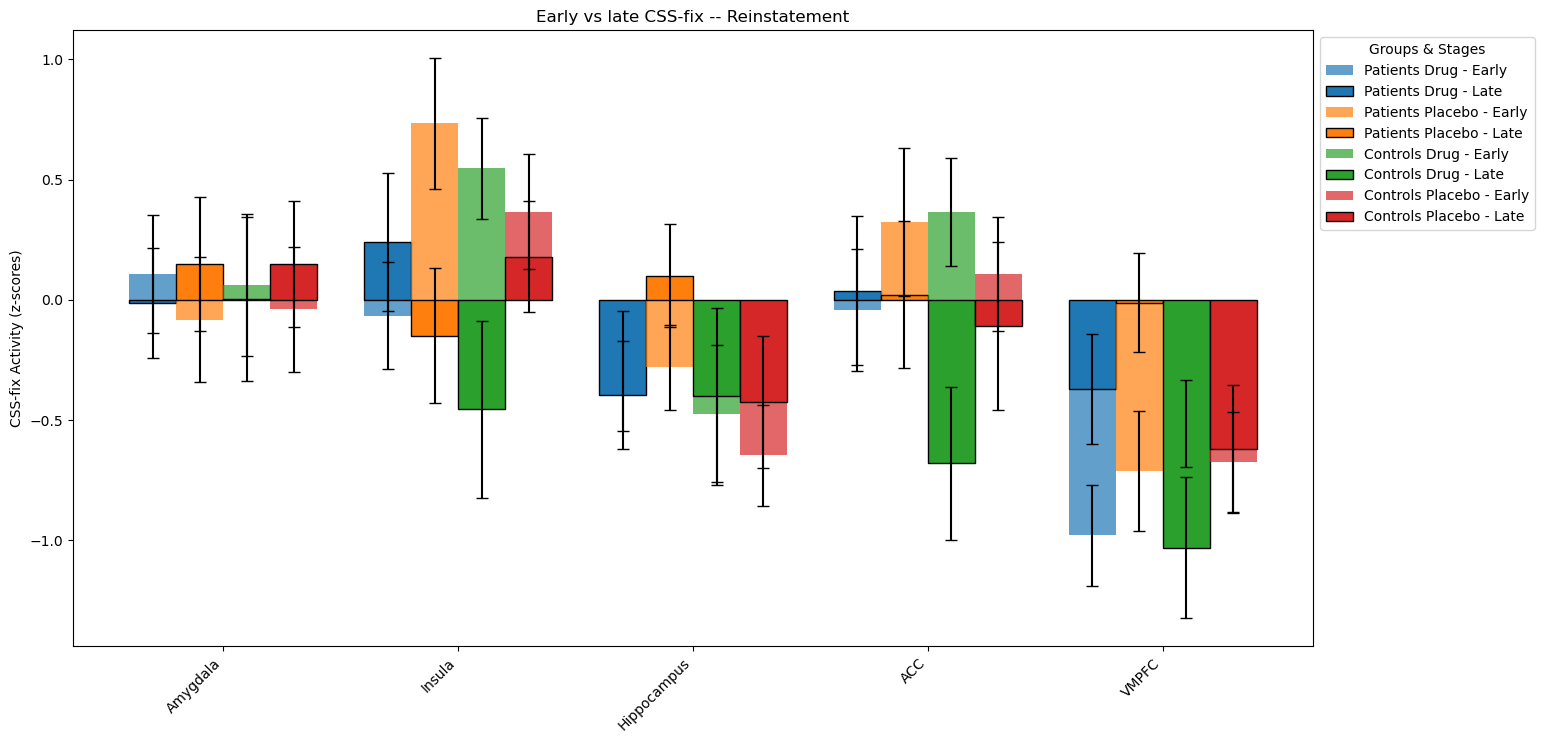

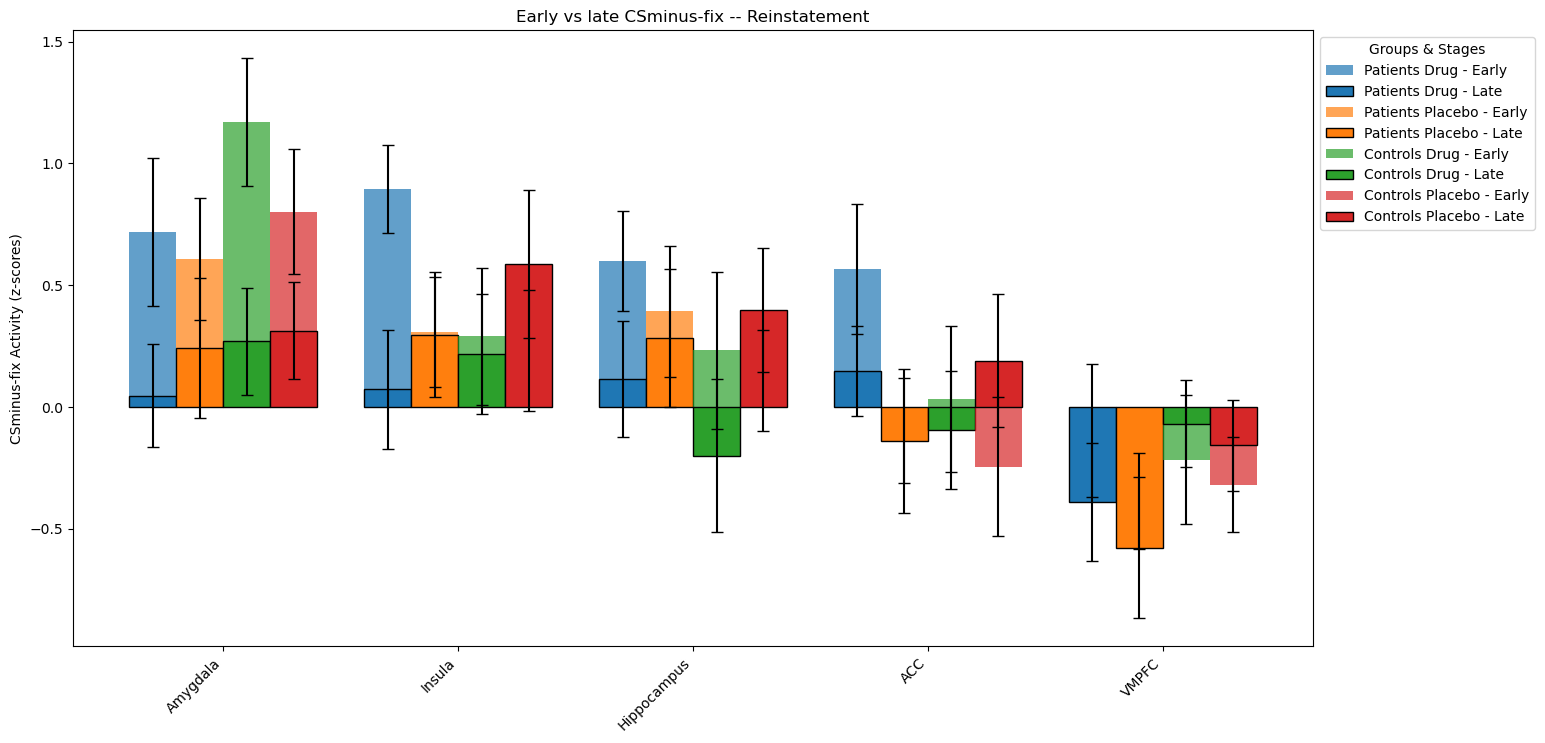

In [ ]:
### one bar plot for all regions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

path = '/Volumes/Seagate Desktop Drive/NARSAD'
os.chdir(path)

# Load and set up drug_order data
drug_order_df = pd.read_excel('drug_order.xlsx', sheet_name='drug_order')
drug_order_df.set_index('subID', inplace=True)


# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

# Function to prepare data for multibar plot with error bars
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each group for both early and late contrasts
    stats = {
        'patients_drug_early': group_stats(patients_drug, data_early),
        'patients_drug_late': group_stats(patients_drug, data_late),
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_drug_early': group_stats(controls_drug, data_early),
        'controls_drug_late': group_stats(controls_drug, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats


# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(16, 8))
    groups = df['Group'].unique()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each group
    
    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.2  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.7, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 1.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs late {title} -- Reinstatement')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout
    plt.savefig(filename, format='png', dpi=300)

    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSS'
plot_multibar_with_error_bars(all_stats, title, filename='CSR-CSS_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CS-early'
    contrast_late = 'CSRlate-CS-late'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-CSminus_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-CS-early'
    contrast_late = 'CSSlate-CS-late'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-CSminus'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-CSminus_reinstatement.png')


all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-fixearly'
    contrast_late = 'CSRlate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSR-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSR-fix_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSSearly-fixearly'
    contrast_late = 'CSSlate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSS-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSS-fix_reinstatement.png')

all_stats = {}
for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSminusearly-fixearly'
    contrast_late = 'CSminuslate-fixlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions
title = 'CSminus-fix'
plot_multibar_with_error_bars(all_stats, title,filename='CSminus-fix_reinstatement.png')


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]


contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx,sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase3, contrast_early, regions_of_interest, sub_order_phase3)
late_data = extract_contrast_data(file_lists_phase3, contrast_late, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
            gender = drug_order_df.loc[subID].values[3]  # Gender coding

            for time, y in zip(time_values, values):
                data.append({
                    'Subject': subID,
                    'Region': region,
                    'y': y,
                    'Time': time,
                    'DrugOrder': drug_order,
                    'PatientGroup': patient_group,
                    'Gender': gender
                })
    
    return pd.DataFrame(data)

# Prepare the regression data
df = prepare_regression_data(early_data, late_data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model with interaction effects, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model with interaction effects
    model = smf.ols('y ~ DrugOrder * PatientGroup * Time + Gender', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.7305
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.664
Time:                        16:33:11   Log-Likelihood:                -327.61
No. Observations:                 202   AIC:                             673.2
Df Residuals:                     193   BIC:                             703.0
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table
def perform_posthoc_tests(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each group
        for group in ['patients_drug', 'patients_placebo', 'controls_drug', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages
        for stage in ['early', 'late']:
            # Patients Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['patients_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Controls Drug vs Placebo
            t_stat, p_val = ttest_ind(stats['controls_drug'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Controls Drug vs Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Drug vs Controls Drug
            t_stat, p_val = ttest_ind(stats['patients_drug'][stage], stats['controls_drug'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Drug vs Controls Drug ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
            
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects
def separate_groups_by_drug(sub_order, drug_order):
    patients_drug = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 1]    
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_drug = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 1]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_drug, patients_placebo, controls_drug, controls_placebo

# Retrieve groups by calling the function
patients_drug, patients_placebo, controls_drug, controls_placebo = separate_groups_by_drug(sub_order_phase3[contrast], drug_order_df)

# Now, populate all_data with actual values
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase3['CSRearly-CSSearly']
    region_data_late = file_lists_phase3['CSRlate-CSSlate']
    region_all_data = {
        'patients_drug': {'early': extract_group_data(patients_drug, region_data_early, region_no),
                          'late': extract_group_data(patients_drug, region_data_late, region_no)},
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_drug': {'early': extract_group_data(controls_drug, region_data_early, region_no),
                          'late': extract_group_data(controls_drug, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table
summary_table = perform_posthoc_tests(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Drug Early vs Late,-0.569364,0.571561
1,Amygdala,Patients Placebo Early vs Late,-0.502464,0.617966
2,Amygdala,Controls Drug Early vs Late,-1.473562,0.147410
3,Amygdala,Controls Placebo Early vs Late,-0.217551,0.828599
4,Amygdala,Patients Drug vs Placebo (Early),0.754667,0.454214
5,Amygdala,Controls Drug vs Placebo (Early),-0.617165,0.539926
6,Amygdala,Patients Drug vs Controls Drug (Early),0.665939,0.508573
7,Amygdala,Patients Placebo vs Controls Placebo (Early),-0.701626,0.486301
8,Amygdala,Patients Drug vs Placebo (Late),0.711254,0.480442
9,Amygdala,Controls Drug vs Placebo (Late),0.762196,0.449524


#### Just placebo ! 

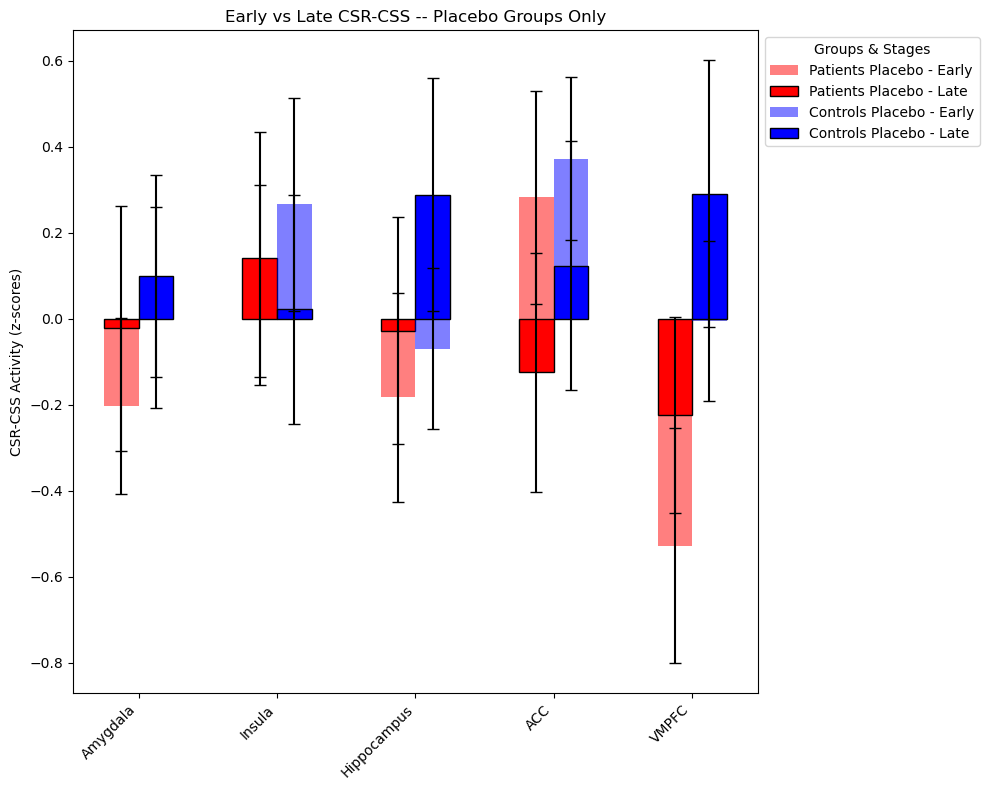

In [ ]:
### just placebo ! 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to prepare data for multibar plot with error bars, only for placebo groups
def prepare_data_for_multibar_plot(all_stats):
    data = []
    for region, stats in all_stats.items():
        for stage in ['early', 'late']:
            for group in ['patients_placebo', 'controls_placebo']:
                mean, se = stats[f'{group}_{stage}']
                data.append({
                    'Region': region,
                    'Stage': 'Early' if stage == 'early' else 'Late',
                    'Group': group.replace('_', ' ').title(),
                    'Mean': mean,
                    'SE': se
                })
    return pd.DataFrame(data)

# Function to calculate mean and standard error for early and late contrasts, only for placebo groups
def extract_stats_early_late(data_early, data_late, sub_order, region_no):
    _, patients_placebo, _, controls_placebo = separate_groups_by_drug(sub_order, drug_order_df)
    
    def group_stats(sub_list, data):
        values = [data[sub_order.index(sub)].z_score()[region_no] for sub in sub_list]
        mean = np.mean(values)
        se = np.std(values) / np.sqrt(len(values))
        return mean, se
    
    # Calculate means and standard errors for each placebo group for both early and late contrasts
    stats = {
        'patients_placebo_early': group_stats(patients_placebo, data_early),
        'patients_placebo_late': group_stats(patients_placebo, data_late),
        'controls_placebo_early': group_stats(controls_placebo, data_early),
        'controls_placebo_late': group_stats(controls_placebo, data_late),
    }
    
    return stats

# Function to plot a multibar plot for each region side by side
def plot_multibar_with_error_bars(all_stats, title, filename):
    df = prepare_data_for_multibar_plot(all_stats)
    
    # Set up the plot
    plt.figure(figsize=(10, 8))
    groups = df['Group'].unique()
    colors = ['red', 'blue']  # Colors for each placebo group

    # Plot each region as a grouped bar with error bars
    x = np.arange(len(regions_of_interest))
    width = 0.25  # Width of each bar

    for i, group in enumerate(groups):
        group_data = df[df['Group'] == group]
        
        # Plot early and late stages for each region
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Early']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Early']['SE'], 
                capsize=4, width=width, color=colors[i], alpha=0.5, label=f'{group} - Early')
        
        plt.bar(x + i*width, group_data[group_data['Stage'] == 'Late']['Mean'],
                yerr=group_data[group_data['Stage'] == 'Late']['SE'],
                capsize=4, width=width, color=colors[i], alpha=1, edgecolor='black', label=f'{group} - Late')
    
    # Customize the plot
    plt.xticks(x + width * 0.5, regions_of_interest, rotation=45, ha='right')
    plt.ylabel(f'{title} Activity (z-scores)')
    plt.title(f'Early vs Late {title} -- Placebo Groups Only')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Groups & Stages')
    plt.tight_layout()
    plt.savefig(filename, format='png', dpi=300)
    plt.show()

# Gather statistics for each region and store in a dictionary for plotting
all_stats = {}
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

for region_no, region in enumerate(regions_of_interest):
    contrast_early = 'CSRearly-CSSearly'
    contrast_late = 'CSRlate-CSSlate'
    region_data_early = file_lists_phase3[contrast_early]
    region_data_late = file_lists_phase3[contrast_late]
    
    stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase3[contrast_early], region_no)
    all_stats[region] = stats

# Plot combined multibar plot across all regions for placebo condition only
title = 'CSR-CSS'
filename = 'CSR-CSS_placebo_reinstatement_ROIs_combined.png'
plot_multibar_with_error_bars(all_stats, title,filename)

# for region_no, region in enumerate(regions_of_interest):
#     contrast_early = 'CSRearly-CS-early'
#     contrast_late = 'CSRlate-CS-late'
#     region_data_early = file_lists_phase2[contrast_early]
#     region_data_late = file_lists_phase2[contrast_late]
    
#     stats = extract_stats_early_late(region_data_early, region_data_late, sub_order_phase2[contrast_early], region_no)
#     all_stats[region] = stats

# # Plot combined multibar plot across all regions for placebo condition only
# title = 'CSR-CS-'
# plot_multibar_with_error_bars(all_stats, title, filename)


In [ ]:
import pandas as pd
import statsmodels.formula.api as smf

# Define regions of interest
# Define regions of interest
regions_of_interest = [
    'Amygdala', 'Insula', 'Hippocampus', 'ACC', 
    'VMPFC'
]

contrast_early = 'CSRearly-CSSearly'
contrast_late = 'CSRlate-CSSlate'

def extract_contrast_data(file_lists, contrast_name, regions, sub_order):
    data = {region: [] for region in regions}
    
    for region_no, region in enumerate(regions):
        # Go through each subject and get the z-scores for the specified region and contrast
        for idx, sub in enumerate(sub_order[contrast_name]):  # Assuming each contrast has a subject order list
            z_score = file_lists[contrast_name][idx].z_score()[region_no]  # Extract z-score for region
            data[region].append(z_score)
            
    return data

# Create dictionaries for early and late contrast data
early_data = extract_contrast_data(file_lists_phase3, contrast_early, regions_of_interest, sub_order_phase3)
late_data = extract_contrast_data(file_lists_phase3, contrast_late, regions_of_interest, sub_order_phase3)

# Function to prepare regression data
def prepare_regression_data(early_data, late_data, sub_order, drug_order_df):
    data = []
    
    for region in early_data.keys():
        for idx, sub in enumerate(sub_order['CSRearly-CSSearly']):
            subID = sub[3:7]
            time_values = [1, 2]  # Early = 1, Late = 2
            values = [early_data[region][idx], late_data[region][idx]]
            drug_order = drug_order_df.loc[subID].values[1]
            
            # Only include placebo subjects
            if drug_order == 0:
                patient_group = 1 if 'N1' in sub else 0  # Patients = 1, Controls = 0
                gender = drug_order_df.loc[subID].values[3]  # Gender coding
                
                for time, y in zip(time_values, values):
                    data.append({
                        'Subject': subID,
                        'Region': region,
                        'y': y,
                        'Time': time,
                        'PatientGroup': patient_group,
                        'Gender': gender
                    })
    
    return pd.DataFrame(data)

# Prepare the regression data for placebo only
df = prepare_regression_data(early_data, late_data, sub_order_phase3, drug_order_df)

# Loop through each region, run the model without DrugOrder, and print summaries
for region in regions_of_interest:
    # Subset data for the current region
    region_df = df[df['Region'] == region]
    
    # Run the linear regression model without DrugOrder
    model = smf.ols('y ~ PatientGroup * Time', data=region_df).fit()
    
    # Print the model summary with a title for each region
    print(f"Model Summary for {region}")
    print(model.summary())
    print("\n" + "="*80 + "\n")


Model Summary for Amygdala
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.023
Method:                 Least Squares   F-statistic:                    0.2628
Date:                Fri, 08 Nov 2024   Prob (F-statistic):              0.852
Time:                        16:39:13   Log-Likelihood:                -160.74
No. Observations:                 100   AIC:                             329.5
Df Residuals:                      96   BIC:                             339.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept  

In [ ]:
from scipy.stats import ttest_ind
import pandas as pd

contrast = 'CSRearly-CSSearly'

# Function to perform post-hoc comparisons and store in summary table (only placebo groups)
def perform_posthoc_tests_placebo(all_data):
    comparisons = []
    
    for region, stats in all_data.items():
        # Early vs Late within each placebo group
        for group in ['patients_placebo', 'controls_placebo']:
            early_vals = stats[group]['early']
            late_vals = stats[group]['late']
            t_stat, p_val = ttest_ind(early_vals, late_vals)
            comparisons.append({
                'Region': region,
                'Comparison': f'{group.replace("_", " ").title()} Early vs Late',
                't_stat': t_stat,
                'p_val': p_val
            })
        
        # Group comparisons within Early and Late stages for placebo groups
        for stage in ['early', 'late']:
            # Patients Placebo vs Controls Placebo
            t_stat, p_val = ttest_ind(stats['patients_placebo'][stage], stats['controls_placebo'][stage])
            comparisons.append({
                'Region': region,
                'Comparison': f'Patients Placebo vs Controls Placebo ({stage.title()})',
                't_stat': t_stat,
                'p_val': p_val
            })
    
    # Convert to DataFrame for easy display
    return pd.DataFrame(comparisons)

# Define extract_group_data to get values for each subject in a specific group and region
def extract_group_data(sub_list, data, region_no):
    values = [data[sub_order_phase3[contrast].index(sub)].z_score()[region_no] for sub in sub_list]
    return values

# Define separate_groups_by_drug function to categorize subjects, keeping only placebo groups
def separate_groups_by_placebo(sub_order, drug_order):
    patients_placebo = [sub for sub in sub_order if sub.startswith('subN1') and drug_order.loc[sub[3:7]].values[1] == 0]
    controls_placebo = [sub for sub in sub_order if sub.startswith('subN2') and drug_order.loc[sub[3:7]].values[1] == 0]
    return patients_placebo, controls_placebo

# Retrieve placebo groups by calling the function
patients_placebo, controls_placebo = separate_groups_by_placebo(sub_order_phase3[contrast], drug_order_df)

# Populate all_data with actual values for placebo groups
all_data = {}
for region_no, region in enumerate(regions_of_interest):
    region_data_early = file_lists_phase3['CSRearly-CSSearly']
    region_data_late = file_lists_phase3['CSRlate-CSSlate']
    region_all_data = {
        'patients_placebo': {'early': extract_group_data(patients_placebo, region_data_early, region_no),
                             'late': extract_group_data(patients_placebo, region_data_late, region_no)},
        'controls_placebo': {'early': extract_group_data(controls_placebo, region_data_early, region_no),
                             'late': extract_group_data(controls_placebo, region_data_late, region_no)},
    }
    all_data[region] = region_all_data

# Run post-hoc tests and display the summary table (placebo only)
summary_table = perform_posthoc_tests_placebo(all_data)

# Display the summary table with all values
pd.set_option('display.max_rows', None)  # Display all rows
display(summary_table)


,Region,Comparison,t_stat,p_val
0,Amygdala,Patients Placebo Early vs Late,-0.502464,0.617966
1,Amygdala,Controls Placebo Early vs Late,-0.217551,0.828599
2,Amygdala,Patients Placebo vs Controls Placebo (Early),-0.701626,0.486301
3,Amygdala,Patients Placebo vs Controls Placebo (Late),-0.327621,0.744623
4,Insula,Patients Placebo Early vs Late,-0.140064,0.889279
5,Insula,Controls Placebo Early vs Late,0.656702,0.514162
6,Insula,Patients Placebo vs Controls Placebo (Early),-0.510501,0.612040
7,Insula,Patients Placebo vs Controls Placebo (Late),0.289853,0.773177
8,Hippocampus,Patients Placebo Early vs Late,-0.422941,0.674496
9,Hippocampus,Controls Placebo Early vs Late,-1.068728,0.289947
